<a href="https://colab.research.google.com/github/AmirHoseein99/Persian_NLP_Task/blob/master/NLP_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install clean-text
!pip install fasttext
!pip install hazm
!pip install imbalanced-learn

In [4]:
import re
import fasttext
import imblearn
from hazm import *
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from cleantext import clean
from sklearn.svm import SVC
from tensorflow import keras
from xgboost import XGBClassifier
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.layers import Embedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer as tf_tokenizer
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, f1_score, roc_curve, auc



---


**My strategy for this problem is to train a model using the labelled data, then predict labels for unlabelled data and use the newly labelled data, alongside the given labelled data to train my final model**


---



### Taking a look at our data

In [5]:
labeled_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/data_labelled.csv", index_col=0)
print(10 * '*' + str(labeled_data.shape) + 10 * '*')
labeled_data.head()

**********(3596, 2)**********


,text,label
id,,
131244574,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...,0
133141894,دوستان این نظرات و پیشنهادات رو باید به پشتیبا...,0
94129372,خیلی ایراد داره مسخره تر از این نمیشه رقیب‌هات...,1
131334220,نه کی گفته خرابه من دارم باهاش کار میکنم از من...,0
131387172,سلام عالیه حتما نصب کنید از کالاف دیوتی هم بهتره,0


In [ ]:
labeled_data.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
unlabeled_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/data_unlabelled.csv", index_col=0)
print(10 * '*' + str(unlabeled_data.shape) + 10 * '*')
unlabeled_data.head()

**********(45755, 1)**********


,text
id,
135828912,باسلام آقامن ازوقتی خودموشناختم مشتری بانک صاد...
135785334,سلام بچه ها میشه با رفیقامون بازی کرد تو این بازی
135166948,سلام، اینکه برای سفارشهای که توسط فروشنده ارسا...
135727408,سلام لطفا همه چیز رو پولی نکنید مثلا هر پیام د...
135362055,روز به روز رو به افول هست آخه هر روز هم آپدیت ...


In [ ]:
unlabeled_data.isnull().sum()

text    0
dtype: int64

### Taking a look at label distribution

0    2460
1    1136
Name: label, dtype: int64


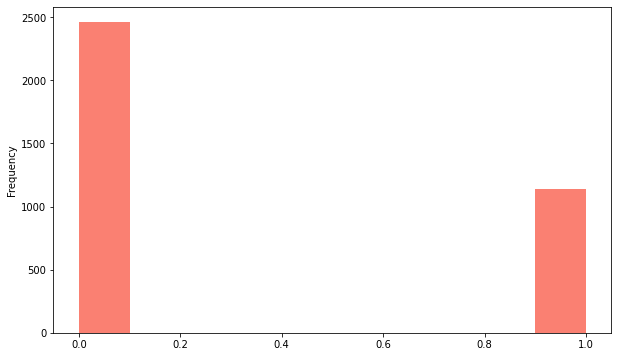

In [ ]:
print(labeled_data.label.value_counts())
_ = labeled_data.label.plot(kind='hist', figsize=(10,6), color = 'salmon')

### Comments length distribution, for all comments

max lenght: 40, min length: 5, average length: 15
25th percentile: 8.0, 50th percentile: 13.0, 75th percentile: 20.0


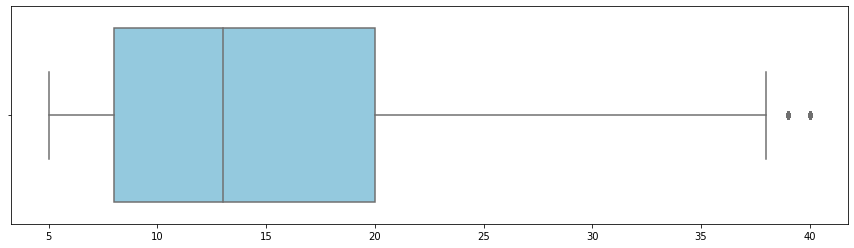

In [ ]:
_ = plt.figure(figsize=(15, 4))
all_comments = np.concatenate([labeled_data.text, unlabeled_data.text])
comment_length = np.array([len(x.split()) for x in all_comments])
print(f"max lenght: {comment_length.max()}, min length: {comment_length.min()}, average length: {int(comment_length.mean())}")
print(f"25th percentile: {np.percentile(comment_length, 25)}, 50th percentile: {np.percentile(comment_length, 50)}, 75th percentile: {np.percentile(comment_length, 75)}")
_ = sns.boxplot(x=comment_length, color='skyblue')
_ = plt.show()

### Comparing comments lenght distribution for different labels

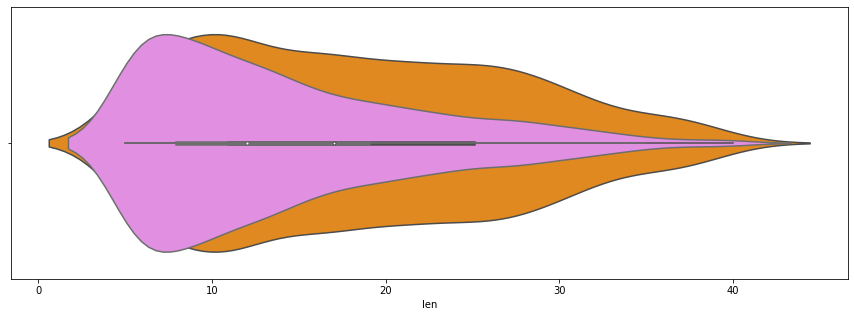

In [ ]:
labeled_data['len'] = labeled_data.text.apply(lambda x : len(x.split(" ")))
_ = sns.violinplot(data=labeled_data[labeled_data.label == 1], x="len", color='darkorange')
_ = sns.violinplot(data=labeled_data[labeled_data.label == 0], x="len", color='violet')

### Taking a look at some of the comments

##### a non-informative comment

In [ ]:
labeled_data.text.iloc[0]

'عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی خیلی خیلی خیلی خیلی خیلی ممنونم که این بازی رو ساختید😍😍😍😍😍😍😍🤩🤩🤩🤩'

#####an informative comment

In [ ]:
labeled_data.text.iloc[2]

'خیلی ایراد داره مسخره تر از این نمیشه رقیب\u200cهات مثل روح از داخل ماشینت رد میشن کلی امتیاز داشتم رفتم بازار سیاه هیچی کارت نداد'

## Preprocessing 

In [ ]:
np.concatenate([unlabeled_data.text, labeled_data.text]).shape

(49351,)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
comment_tokens = Tokenizer(char_level=True)
comment_tokens.fit_on_texts(np.concatenate([unlabeled_data.text, labeled_data.text]))
vocab = np.array(list(comment_tokens.word_index.keys()))
vocab

array([' ', 'ا', 'ی', 'ن', 'م', 'ه', 'ر', 'د', 'ب', 'و', 'ت', 'ل', 'ک',
       'س', 'ش', 'ز', 'خ', 'ع', 'ف', 'گ', 'ق', 'چ', 'پ', 'ص', 'ح', '.',
       'ج', 'ط', 'آ', 'ض', '،', '۰', 'ظ', '\u200c', '؟', 'ث', 'ذ', '۱',
       '❤', 'غ', '0', '️', 'ـ', '۵', '😍', '!', '۲', 'ً', '1', '😡', '👍',
       '۳', '5', '2', '🤮', '👌', '۴', '🤩', '♥', '🏻', '😘', '😂', '🙏', 'ي',
       'ژ', 'a', '😐', '🥰', '⭐', 'e', '🌹', '😠', '3', 'ئ', 'o', ')', '۹',
       '۶', '🤣', '4', 's', '🤬', 'i', '(', 'n', '۸', 'r', ':', 't', '۷',
       'p', '😑', '💙', '😭', '😒', '😊', 'l', '💜', '6', '👎', '🌟', '💖', '9',
       '🤢', '👏', '8', '😤', '♡', 'm', '😔', 'h', 'd', '😁', '7', 'َ', 'g',
       'ِ', '/', '_', 'c', '😎', '🤔', '😉', '\u2066', 'u', '*', '\u200d',
       '-', 'v', '🙂', '💋', '💛', '😅', '\U0001fae3', 'ء', '\u2069', '☺',
       'y', '😏', '👑', '🤗', '💗', 'k', 'b', '👽', '😕', '😇', 'f', '☆', '🥺',
       '💚', 'ك', '💔', '🏼', 'أ', '💓', '💞', '💕', '🙄', '☹', '💝', ',', '😀',
       '😙', '😆', '🧡', 'ہ', '😈', '🖤', '😜', '😣', '😢', '🤨', '🔥', '"'

#### Cleaning comments, deleting useless chars, normalizing and finally lematizing the tokens

In [ ]:

def cleaning(text):
  # remove spaces
  text = text.strip()
  
  # normalizing


  # regular cleaning
  text = clean(text,
               fix_unicode=True,
               to_ascii=False,
               lower=True,
               no_line_breaks=True,
               no_urls=True,
               no_emails=True,
               no_phone_numbers=True,
               no_numbers=True,
               no_digits=True,
               no_currency_symbols=True,
               no_punct=True,
               replace_with_url="URL",
               replace_with_email="EMAIL",
               replace_with_phone_number="",
               replace_with_number="NUM",
               replace_with_digit="DIGIT",
               replace_with_currency_symbol="",
               )

    
  # removing emojies and unsusual patterns
  wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
  text = wierd_pattern.sub(r'', text)

  text = Normalizer().normalize(text)

  return text

In [ ]:
!git clone https://github.com/kharazi/persian-stopwords.git

Cloning into 'persian-stopwords'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 51 (delta 7), reused 5 (delta 5), pack-reused 42
Unpacking objects: 100% (51/51), 34.96 KiB | 813.00 KiB/s, done.


In [ ]:
with open("/content/persian-stopwords/persian", "r") as f:
  content = f.read()
  stopwords_p = content.split("\n")
  stopwords_p = stopwords_p[:-1]        
with open("/content/persian-stopwords/short", "r") as f:
  content = f.read()
  stopwords_s = content.split("\n")
  stopwords_s = stopwords_s[:-1]

with open("/content/persian-stopwords/verbal", "r") as f:
  content = f.read()
  stopwords_v = content.split("\n")
  stopwords_v = stopwords_v[:-1]

with open("/content/persian-stopwords/nonverbal", "r") as f :
  content = f.read()
  stopwords_nv = content.split("\n")
  stopwords_nv = stopwords_nv[:-1]
  

fa_stopwords = set(stopwords_p + stopwords_s + stopwords_v + stopwords_nv)

In [ ]:
hzm_tokenize = WordTokenizer().tokenize
hzm_lemmaitze = Lemmatizer(joined_verb_parts=False).lemmatize


def my_toknizer(text):
  text_tokens = hzm_tokenize(text)
  clean_tokens = [hzm_lemmaitze(token) for token in text_tokens if token not in fa_stopwords]
  return ' '.join(clean_tokens)


In [ ]:
print(f'before clean : {labeled_data.text.iloc[0]}')
print(f'before clean : {unlabeled_data.text.iloc[0]}')

labeled_data.text = labeled_data.text.apply(lambda x : cleaning(x))
unlabeled_data.text = unlabeled_data.text.apply(lambda x : cleaning(x))

labeled_data.text = labeled_data.text.apply(lambda x : my_toknizer(x))
unlabeled_data.text = unlabeled_data.text.apply(lambda x : my_toknizer(x))

print(f'after clean : {labeled_data.text.iloc[0]}')
print(f'after clean : {unlabeled_data.text.iloc[0]}')

before clean : عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی خیلی خیلی خیلی خیلی خیلی ممنونم که این بازی رو ساختید😍😍😍😍😍😍😍🤩🤩🤩🤩
before clean : باسلام آقامن ازوقتی خودموشناختم مشتری بانک صادرات بودم ح جاری پس انداز و....ولی امروزازصبح تاحالانتونستم توبرنامه صاپ ثبت‌نام بکنم خداوکیلی
after clean : عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی ممنون بازی ساخت#ساز
after clean : باسلام آقامن ازوقتی خودموشناختم مشتری بانک صادرات جاری انداز وولی امروزازصبح تاحالانتونستم توبرنامه صاپ ثبتنام خداوکیلی


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
comment_tokens = Tokenizer(char_level=True)
comment_tokens.fit_on_texts(np.concatenate([unlabeled_data.text, labeled_data.text]))
vocab = np.array(list(comment_tokens.word_index.keys()))
vocab

array([' ', 'ا', 'ی', 'ن', 'ر', 'م', 'ه', 'د', 'ب', 'و', 'ت', 'ل', 'س',
       'ش', 'ک', 'ز', 'ع', 'خ', 'ف', 'گ', 'پ', 'i', '#', 'ص', 'ق', 'ح',
       'ج', 't', 'd', 'g', 'n', 'چ', 'm', 'u', 'ط', 'ض', 'آ', '\u200c',
       'ظ', 'ذ', 'غ', 'ث', '_', 'a', 'ژ', 'e', 'ئ', 'o', 's', 'r', 'p',
       'l', 'h', 'c', 'v', 'ء', 'y', 'k', 'b', 'f', 'أ', 'ہ', 'x', '^',
       'ى', 'w', '+', 'z', 'j', 'ے', 'ە', '~', '=', 'ھ', '̶', '|', 'ڪ',
       '͟', '͞', 'ؤ', 'q', '˘', 'ة', 'إ', 'ࢪ', 'ٰ', '`', '⃢', '°', '∩',
       '√', '⃣', '³', 'ێ', 'ಠ', 'ٱ', 'ω', 'ᴗ', 'ۆ', '´', '×', 'ٻ', 'ٺ',
       '←', 'ლ', '͡', 'ರ', 'ۥ', 'ٖ', 'ᴥ', '>', 'ฅ', '®', '⇴', 'ڼ', '⃠',
       'כ', 'ʖ', '↓', 'ʕ', 'ʔ', 'ݪ', 'ݕ', 'ݩ', '͜', '\u200b', 'ঔ', 'ৣ',
       'ᴇ', '↑', 'ט', 'ּ', '؏', '۬', '⁴', 'ۍ', 'ღ', '↯', 'ۅ', '۽', '™',
       'ۂ', '⁰', '⃞', 'ತ', '²', 'ə', 'ᴘ', 'ʜ', 'ʀ', '¹', 'ݘ', 'ں', 'ℳ',
       'ʍ', 'ო', 'ڔ', 'ٔ', 'ב', '∆', 'ګ', 'ĺ', 'ݒ', 'ݟ', 'ڰ', 'ڌ', '٘',
       'ڐ', '⁵', 'ڋ', 'ٶ', 'ᕙ', 'ᕗ', '⃟', '⃤', 'ඞ', '¢', 'ڱ', 'ڸ

#### First we split the data to train and test to limit the lekage, and have a real understanding of our model's performance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())

print(f'train data shape for semi_supervised learning : {X_train.shape}')
print(f'train label shape for semi_supervised learning : {y_train.shape}')

print(f'validation data shape for semi_supervised learning : {X_test.shape}')
print(f'validation label shape for semi_supervised learning : {y_test.shape}')


train data shape for semi_supervised learning : (2876,)
train label shape for semi_supervised learning : (2876,)
validation data shape for semi_supervised learning : (720,)
validation label shape for semi_supervised learning : (720,)


### Vectorizing data for our gru model

In [ ]:
train_median_len = int(np.percentile([len(txt.split(" ")) for txt in X_train], 50))
print(f'Train comments median lenght {train_median_len}')


vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=train_median_len)
text_ds = tf.data.Dataset.from_tensor_slices(X_train)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

Train comments median lenght 7


In [ ]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'عالی', 'بازی', 'نصب']

In [ ]:
output = vectorizer([[" باسلام آقامن ازوقتی خودموشناختم مشتری بانک صادرات بودم ح جاری پس‌انداز وولی امروزازصبح تاحالانتونستم توبرنامه صاپ ثبت‌نام بکنم خداوکیلی"]])
output.numpy()

array([[ 504,    1, 5941,    1,  339,  134, 4101]])

#### We use pretrained word embedding from fasttest for one of our models
creating the embedding matrix for our vocab

In [ ]:
persain_embeding = fasttext.load_model('/content/drive/MyDrive/Persian_Nlp/classification/cc.fa.100.bin')


num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = persain_embeding.get_word_vector(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

persain_embeding=None
print(embedding_matrix.shape)

Converted 6323 words (0 misses)
(6325, 100)


In [ ]:
#creating the embedding layer

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


##### we use costum weights for trainning our model, 

In [ ]:
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

{0: 0.7277327935222672, 1: 1.5977777777777777}


## Model Trainning

### Our first model is a GRU with pretrained Embedding 

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
                     filepath='/content/drive/MyDrive/Cafe_Bazar/tmp/pretrained_gru_model.hdf5', 
                     save_freq='epoch', monitor='val_loss', 
                     save_weights_only=False, save_best_only=True),
            keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
             ]

In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.GRU(15, return_sequences=True)(embedded_sequences)
x = layers.GRU(5)(x)
preds = layers.Dense(1, activation="sigmoid", kernel_initializer=keras.initializers.Constant(initial_bias))(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         632500    
                                                                 
 gru (GRU)                   (None, None, 15)          5265      
                                                                 
 gru_1 (GRU)                 (None, 5)                 330       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 638,101
Trainable params: 5,601
Non-trainable params: 632,500
_________________________________________________________________


In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
model.compile( loss=keras.losses.BinaryCrossentropy(), 
                optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size = 32, validation_split=0.1, callbacks=callbacks, class_weight=class_weights)

Epoch 1/100
81/81 [==============================] - 1s 11ms/step - loss: 0.5498 - accuracy: 0.7318 - auc: 0.7909 - prc: 0.6010 - val_loss: 0.5818 - val_accuracy: 0.6979 - val_auc: 0.7586 - val_prc: 0.6619
Epoch 2/100
81/81 [==============================] - 1s 11ms/step - loss: 0.5457 - accuracy: 0.7249 - auc: 0.7958 - prc: 0.6083 - val_loss: 0.5849 - val_accuracy: 0.7014 - val_auc: 0.7584 - val_prc: 0.6632
Epoch 3/100
81/81 [==============================] - 1s 11ms/step - loss: 0.5544 - accuracy: 0.7179 - auc: 0.7862 - prc: 0.5970 - val_loss: 0.5963 - val_accuracy: 0.6910 - val_auc: 0.7592 - val_prc: 0.6638
Epoch 4/100
81/81 [==============================] - 1s 11ms/step - loss: 0.5446 - accuracy: 0.7249 - auc: 0.7969 - prc: 0.6088 - val_loss: 0.5661 - val_accuracy: 0.7049 - val_auc: 0.7589 - val_prc: 0.6637
Epoch 5/100
81/81 [==============================] - 1s 10ms/step - loss: 0.5499 - accuracy: 0.7276 - auc: 0.7909 - prc: 0.6066 - val_loss: 0.5806 - val_accuracy: 0.7049 - val_

In [ ]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 4ms/step - loss: 0.5431 - accuracy: 0.7208 - auc: 0.7590 - prc: 0.5869


[0.5431044101715088,
 0.7208333611488342,
 0.7589735984802246,
 0.5869479775428772]

#### evaluating model performance

23/23 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       484
           1       0.60      0.44      0.51       236

    accuracy                           0.72       720
   macro avg       0.68      0.65      0.66       720
weighted avg       0.71      0.72      0.71       720



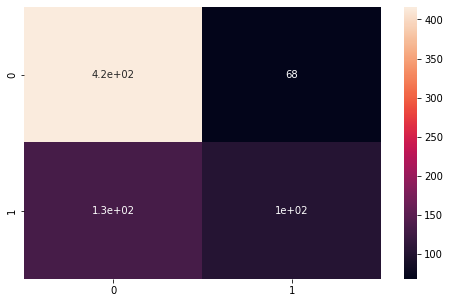

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred  = [1 if prob > .5 else 0 for prob in y_pred_proba] 
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  y_pred), annot=True)

print(classification_report(y_test.reshape(-1),  y_pred))

logesitc Regressin Model AUC is : 0.7591661997478638


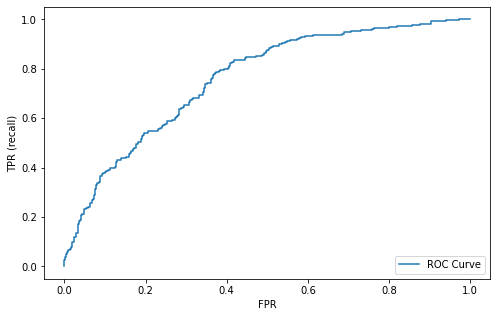

In [ ]:
_ = plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print(f'GRU with pretrained Embedding Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_ = plt.xlabel("FPR")
_ = plt.ylabel("TPR (recall)")
_ = plt.legend(loc=4)

#### Fine Tunning Embedding Layer

In [ ]:

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.GRU(15, return_sequences=True)(embedded_sequences)
x = layers.GRU(10)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
trainable_embed_model = keras.Model(int_sequences_input, preds)


trainable_embed_model.compile(  loss=keras.losses.BinaryCrossentropy(), 
                optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                metrics=METRICS)
trainable_embed_model_history = trainable_embed_model.fit(X_train,y_train, epochs=100, verbose=1, batch_size = 32, validation_split=0.1, callbacks=callbacks, class_weight=class_weights)

Epoch 1/100
81/81 [==============================] - 8s 45ms/step - loss: 0.6894 - accuracy: 0.5777 - auc: 0.4824 - prc: 0.2921 - val_loss: 0.6891 - val_accuracy: 0.5903 - val_auc: 0.5331 - val_prc: 0.4155
Epoch 2/100
81/81 [==============================] - 1s 18ms/step - loss: 0.6879 - accuracy: 0.6051 - auc: 0.5366 - prc: 0.3196 - val_loss: 0.6868 - val_accuracy: 0.6146 - val_auc: 0.5556 - val_prc: 0.4260
Epoch 3/100
81/81 [==============================] - 1s 17ms/step - loss: 0.6862 - accuracy: 0.6294 - auc: 0.5713 - prc: 0.3397 - val_loss: 0.6850 - val_accuracy: 0.6076 - val_auc: 0.5792 - val_prc: 0.4506
Epoch 4/100
81/81 [==============================] - 1s 17ms/step - loss: 0.6849 - accuracy: 0.6264 - auc: 0.5907 - prc: 0.3518 - val_loss: 0.6842 - val_accuracy: 0.6181 - val_auc: 0.5880 - val_prc: 0.4590
Epoch 5/100
81/81 [==============================] - 1s 17ms/step - loss: 0.6834 - accuracy: 0.6345 - auc: 0.6049 - prc: 0.3644 - val_loss: 0.6821 - val_accuracy: 0.6146 - val_

23/23 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       484
           1       0.55      0.58      0.56       236

    accuracy                           0.71       720
   macro avg       0.67      0.67      0.67       720
weighted avg       0.71      0.71      0.71       720



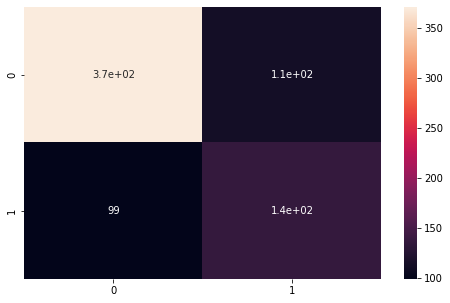

In [ ]:
trainable_y_pred_proba = trainable_embed_model.predict(X_test)
trainable_y_pred  = [1 if prob > .5 else 0 for prob in trainable_y_pred_proba] 
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  trainable_y_pred), annot=True)
print(classification_report(y_test.reshape(-1),  trainable_y_pred))

GRU with traineable Embedding Model AUC is : 0.7544211374142037


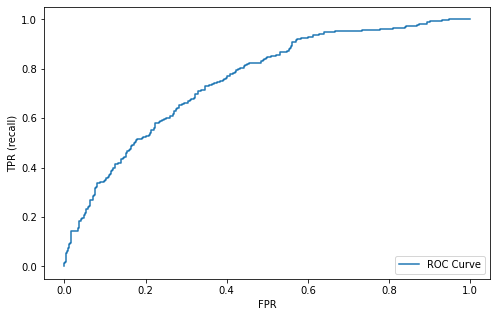

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, trainable_y_pred_proba)
print(f'GRU with traineable Embedding Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Train with trainable embedding layer

In [ ]:

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=True,
)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.GRU(15, return_sequences=True)(embedded_sequences)
x = layers.GRU(10)(x)
preds = layers.Dense(1, activation="sigmoid", kernel_initializer=keras.initializers.Constant(initial_bias))(x)
empyt_embed_model = keras.Model(int_sequences_input, preds)


empyt_embed_model.compile(  loss=keras.losses.BinaryCrossentropy(), 
                optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                metrics=METRICS)
empyt_embed_model_history = empyt_embed_model.fit(X_train,y_train, epochs=100, verbose=1, batch_size = 32, validation_split=0.1, callbacks=callbacks, class_weight=class_weights)

23/23 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       484
           1       0.55      0.50      0.53       236

    accuracy                           0.70       720
   macro avg       0.66      0.65      0.65       720
weighted avg       0.70      0.70      0.70       720



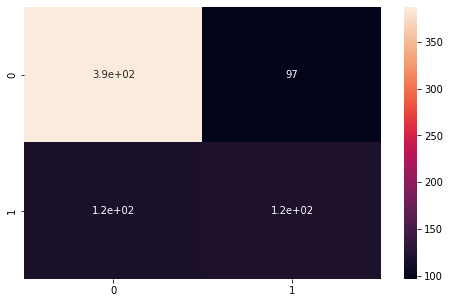

In [ ]:
empty_embed_y_pred_proba = empyt_embed_model.predict(X_test)
empty_embed_y_pred  = [1 if prob > .5 else 0 for prob in empty_embed_y_pred_proba] 
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  empty_embed_y_pred), annot=True)
print(classification_report(y_test.reshape(-1),  empty_embed_y_pred))

logesitc Regressin Model AUC is : 0.7535281552038101


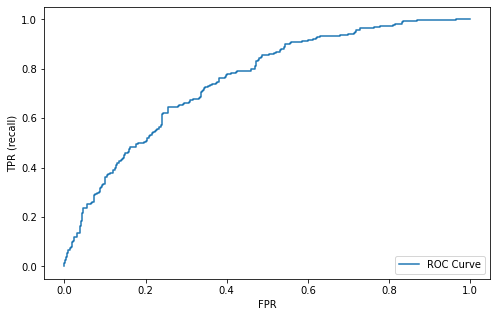

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, empty_embed_y_pred_proba)
print(f'GRU with traineable Embedding Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Using Fast Text for classification

In [ ]:
train, test = train_test_split(labeled_data, test_size = 0.2, random_state=42, stratify=labeled_data.label)

print(f'Train data shape for semi_supervised learning : {train.shape}')
print(f'Test data shape for semi_supervised learning : {test.shape}')

Train data shape for semi_supervised learning : (2876, 2)
Test data shape for semi_supervised learning : (720, 2)


In [ ]:
ft_train_data = pd.DataFrame()
ft_train_data['label'] = "__label__" + train['label'].astype('str')
ft_train_data['fasttext_input'] =ft_train_data['label'] + ' ' + train['text'] 
print(ft_train_data.shape)
ft_train_data.head()

(2876, 2)


,label,fasttext_input
id,,
131243005,__label__0,__label__0 برنامه خوبی ممنون سازندش digitتا ست...
42525407,__label__1,__label__1 سلام نقشه قبله نما صبا قید خلیج عرب...
131388135,__label__0,__label__0 اثلا بدرد نمیخوره ستاره میدم
95173922,__label__0,__label__0 نسبت کارایی‌ها
132712538,__label__0,__label__0 بازی خوبیه ایکس لیندسی رفتن سمت کال...


In [ ]:
ft_test_data = pd.DataFrame()
ft_test_data['label'] = "__label__" + test['label'].astype('str')
ft_test_data['fasttext_input'] =ft_test_data['label'] + ' ' + test['text']
ft_test_data['text'] =  test['text']
print(ft_test_data.shape)
ft_test_data.head()

(720, 3)


,label,fasttext_input,text
id,,,
132745414,__label__0,__label__0 سلام مسول خواهشن کرایهانظربکنید کرا...,سلام مسول خواهشن کرایهانظربکنید کرایه پاینه کر...
131760123,__label__0,__label__0 عالی فقد ماشین آخرو بازنمیکن,عالی فقد ماشین آخرو بازنمیکن
132695550,__label__1,__label__1 من نمیدونم چجوری راش بندازم,من نمیدونم چجوری راش بندازم
131726241,__label__0,__label__0 برنامه خوبی اینترنتم میبره رایگان س...,برنامه خوبی اینترنتم میبره رایگان سازندش خدا ر...
93966691,__label__0,__label__0 بلا سر اوردین قبلنا نظرمن همون نسخه...,بلا سر اوردین قبلنا نظرمن همون نسخه قدیم بهتره


In [ ]:
ft_train_data.to_csv("comment.train", columns=['fasttext_input'], index=False, header=False)
ft_test_data.to_csv("comment.test", columns=['fasttext_input'], index=False, header=False)

In [ ]:
ft_model = fasttext.train_supervised(input='comment.train', epoch=50, lr=0.01)
ft_model.test("comment.test")

(720, 0.7597222222222222, 0.7597222222222222)

In [ ]:
ft_test_data['ft_label'] = ft_test_data.text.apply(lambda x : ft_model.predict(x)[0][0])
ft_test_data['ft_label'] = ft_test_data.ft_label.apply(lambda x : 1 if x=='__label__1' else 0)
ft_test_data.head()

,label,fasttext_input,text,ft_label
id,,,,
132745414,__label__0,__label__0 سلام مسول خواهشن کرایهانظربکنید کرا...,سلام مسول خواهشن کرایهانظربکنید کرایه پاینه کر...,0
131760123,__label__0,__label__0 عالی فقد ماشین آخرو بازنمیکن,عالی فقد ماشین آخرو بازنمیکن,0
132695550,__label__1,__label__1 من نمیدونم چجوری راش بندازم,من نمیدونم چجوری راش بندازم,0
131726241,__label__0,__label__0 برنامه خوبی اینترنتم میبره رایگان س...,برنامه خوبی اینترنتم میبره رایگان سازندش خدا ر...,0
93966691,__label__0,__label__0 بلا سر اوردین قبلنا نظرمن همون نسخه...,بلا سر اوردین قبلنا نظرمن همون نسخه قدیم بهتره,0


              precision    recall  f1-score   support

           0       0.79      0.88      0.83       484
           1       0.68      0.51      0.58       236

    accuracy                           0.76       720
   macro avg       0.73      0.70      0.71       720
weighted avg       0.75      0.76      0.75       720



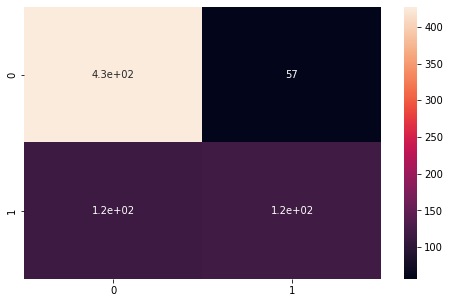

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,   ft_test_data.ft_label), annot=True)
print(classification_report(y_test.reshape(-1),   ft_test_data.ft_label))

### Trying with some ml models aswell


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([484, 236]))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([493, 227]))


#### Using Word level Vectorizer

In [ ]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()
print(X_train.shape, X_test.shape)

(2876, 6213) (720, 6213)


In [ ]:
len(tfidf.vocabulary_)

6253

##### Baseline Model

In [ ]:
strategies = ["stratified", "most_frequent", "uniform"]
for strategy in strategies:
    cv_results = cross_val_score(DummyClassifier(strategy=strategy), X_train, y_train, scoring="f1_macro", cv=3)
    print(f"{strategy} strategy scores: {cv_results}")

stratified strategy scores: [0.52354928 0.48375493 0.50789824]
most_frequent strategy scores: [0.40729295 0.40729295 0.40717822]
uniform strategy scores: [0.47749194 0.47363575 0.50663611]


##### Weights for imbalance dataset

In [ ]:
print(np.unique(y_train, return_counts=True))
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

(array([0, 1]), array([1967,  909]))
{0: 0.7310625317742755, 1: 1.5819581958195819}


#### Finding the best model

In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), SVC(), XGBClassifier(scale_pos_weight=class_weights.get(0)/class_weights.get(1))
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.4902701796626183, f1_macro:0.4877588704388509

Model: KNeighborsClassifier, Best params: {}
acc:0.6867177085850417, f1_macro:0.40713252633757113

Model: RandomForestClassifier, Best params: {}
acc:0.7486040390890825, f1_macro:0.6359449274390537

Model: SGDClassifier, Best params: {}
acc:0.7440883459124015, f1_macro:0.6914209073653063

Model: LogisticRegression, Best params: {}
acc:0.737484244417789, f1_macro:0.7095377607382689

Model: SVC, Best params: {}
acc:0.740608149146314, f1_macro:0.6048476803021928

Model: XGBClassifier, Best params: {}
acc:0.7176625065398818, f1_macro:0.5253224336590233



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       484
           1       0.58      0.65      0.61       236

    accuracy                           0.73       720
   macro avg       0.70      0.71      0.70       720
weighted avg       0.74      0.73      0.73       720



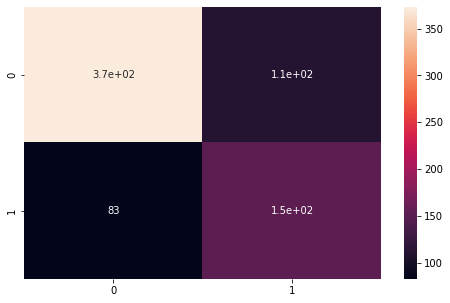

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.8021650441238269


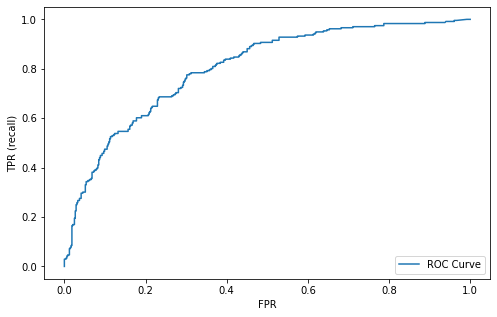

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Dimentionality Reduction

In [ ]:
pca = PCA(n_components=0.9, random_state=28)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)
print(f"Expained variance: {np.cumsum(pca.explained_variance_)[-1]}")

(2876, 1586) (720, 1586)
Expained variance: 0.8863639110292445


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), SVC(), XGBClassifier(scale_pos_weight=class_weights.get(0)/class_weights.get(1))
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.4012661066133172, f1_macro:0.3706627617944324

Model: KNeighborsClassifier, Best params: {}
acc:0.6874132399862708, f1_macro:0.41162454289401057

Model: RandomForestClassifier, Best params: {}
acc:0.6874128771634219, f1_macro:0.4168463891875893

Model: SGDClassifier, Best params: {}
acc:0.7204446321447983, f1_macro:0.6773524672055357

Model: LogisticRegression, Best params: {}
acc:0.7350504287477605, f1_macro:0.7089820722971654

Model: SVC, Best params: {}
acc:0.7440861689753083, f1_macro:0.6195457484632542

Model: XGBClassifier, Best params: {}
acc:0.7190571975708284, f1_macro:0.5566134909438275



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       484
           1       0.58      0.67      0.62       236

    accuracy                           0.73       720
   macro avg       0.70      0.72      0.71       720
weighted avg       0.75      0.73      0.74       720



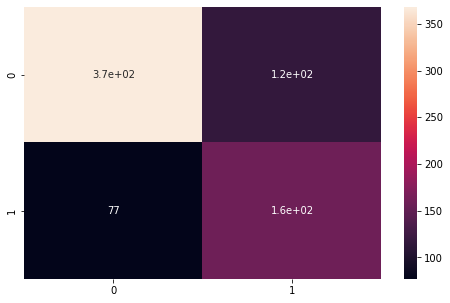

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

dim_reduced logesitc Regressin Model AUC is : 0.7989520591119205


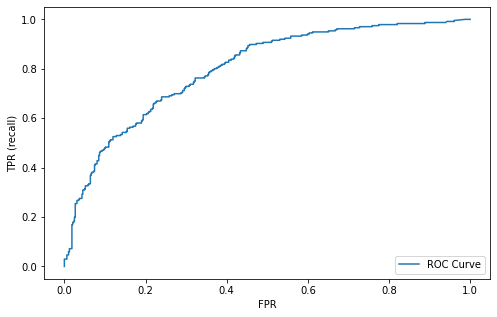

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'dim_reduced logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Testing models with better results in pca

In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [SVC()]


rf_params = {
      'C' : [0.1, 0.01, 1, 10],
      'kernel' :['linear'],
      'gamma' : ['auto', 0.1, 1],
      'degree' : [1]
}

cv_results={}
for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid=rf_params, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

In [ ]:
svc_model = SVC(C=1, kernel='linear',  degree=1, probability=True)
svc_model.fit(X_train, y_train)
svc_preds = svc_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       484
           1       0.65      0.51      0.57       236

    accuracy                           0.75       720
   macro avg       0.72      0.69      0.70       720
weighted avg       0.74      0.75      0.74       720



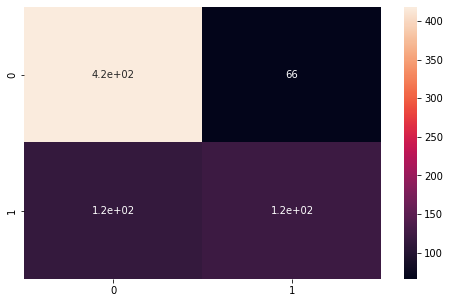

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  svc_preds), annot=True)
print(classification_report(y_test.reshape(-1),  svc_preds))

SVC Model AUC is : 0.7984180207311948


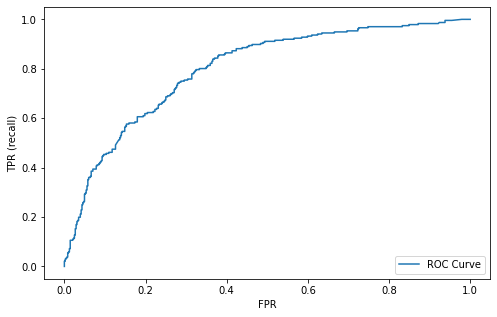

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, svc_model.predict_proba(X_test)[:, 1])
print(f'SVC Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [XGBClassifier(tree_method='gpu_hist')]


xg_params = {
      'booster' : ['gbtree', 'gblinear', 'dart'],
      'eta' : [0.3, 0.05, 1],
      'max_depth' :[8, 20, 3],
      'scale_pos_weight':[class_weights.get(0)/class_weights.get(1), 1, 2]
}

cv_results={}
for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid=xg_params, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: XGBClassifier, Best params: {'booster': 'gbtree', 'eta': 0.3, 'max_depth': 20, 'scale_pos_weight': 2}
acc:0.7180148075261069, f1_macro:0.6735219749910145



In [ ]:
xg_model = XGBClassifier(eta=0.3, max_depth=20, booster='gbtree', scale_pos_weight=2)
xg_model.fit(X_train, y_train)
xg_preds = xg_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       493
           1       0.67      0.42      0.52       227

    accuracy                           0.75       720
   macro avg       0.72      0.66      0.68       720
weighted avg       0.74      0.75      0.73       720



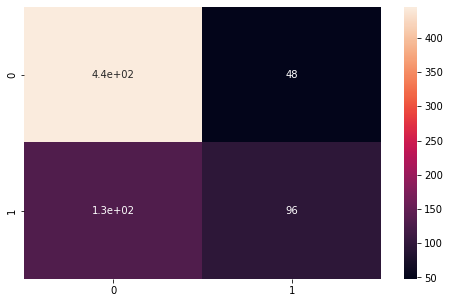

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  xg_preds), annot=True)
print(classification_report(y_test.reshape(-1),  xg_preds))

XGboost Model AUC is : 0.7763267239145393


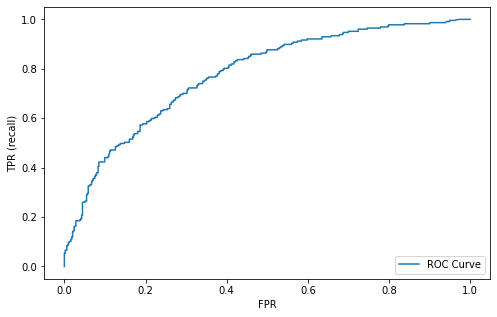

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, xg_model.predict_proba(X_test)[:, 1])
print(f'XGboost Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### char_ngrams vectorizing 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42,  stratify=labeled_data.label.to_numpy())
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,4))
X_train = tfidf.fit_transform(X_train).toarray()
train_vocab = len(tfidf.vocabulary_)

X_test = tfidf.transform(X_test).toarray()
test_vocab = len(tfidf.vocabulary_)

print(X_train.shape, X_test.shape)

(2876, 20674) (720, 20674)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier()
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.5166902138695565, f1_macro:0.49928416918860163

Model: KNeighborsClassifier, Best params: {}
acc:0.6867198855221348, f1_macro:0.4348152957224598

Model: RandomForestClassifier, Best params: {}
acc:0.771905973733077, f1_macro:0.7155726968414257

Model: SGDClassifier, Best params: {}
acc:0.7454837625890457, f1_macro:0.7001947663458834

Model: LogisticRegression, Best params: {}
acc:0.7527892006504687, f1_macro:0.7255036976455843

Model: XGBClassifier, Best params: {}
acc:0.7569525928409245, f1_macro:0.6832277014448257



In [ ]:
pca = PCA(n_components=0.9, random_state=28)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)
print(f"Expained variance: {np.cumsum(pca.explained_variance_)[-1]}")

(2876, 1303) (720, 1303)
Expained variance: 0.8754288000319302


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier()
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.5796261908752957, f1_macro:0.5700822981256484

Model: KNeighborsClassifier, Best params: {}
acc:0.6888072053715198, f1_macro:0.45151704623199823

Model: RandomForestClassifier, Best params: {}
acc:0.6874128771634219, f1_macro:0.4278368084110169

Model: SGDClassifier, Best params: {}
acc:0.7267102199214417, f1_macro:0.6931256352717554

Model: LogisticRegression, Best params: {}
acc:0.748616375065943, f1_macro:0.7217316975691571

Model: XGBClassifier, Best params: {}
acc:0.7360910046782378, f1_macro:0.6554308494138869



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())

tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(X_train).toarray()
train_vocab = len(tfidf.vocabulary_)

X_test = tfidf.transform(X_test).toarray()
test_vocab = len(tfidf.vocabulary_)

print(X_train.shape, X_test.shape)

(2876, 38217) (720, 38217)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier(tree_method='gpu_hist')
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.5427720971813744, f1_macro:0.520044944649096

Model: KNeighborsClassifier, Best params: {}
acc:0.6877637268582516, f1_macro:0.43800090944865433

Model: RandomForestClassifier, Best params: {}
acc:0.7646038010772935, f1_macro:0.6981298419259004

Model: SGDClassifier, Best params: {}
acc:0.7486109327232103, f1_macro:0.7060028671720658

Model: LogisticRegression, Best params: {}
acc:0.752440890715581, f1_macro:0.7262071485706535

Model: XGBClassifier, Best params: {}
acc:0.7586930540468172, f1_macro:0.6888845494242842



In [ ]:
pca = PCA(n_components=0.9, random_state=28)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)
print(f"Expained variance: {np.cumsum(pca.explained_variance_)[-1]}")

(2876, 1351) (720, 1351)
Expained variance: 0.863416086585446


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier(tree_method='gpu_hist')
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.5744124265374436, f1_macro:0.5630099063148367

Model: KNeighborsClassifier, Best params: {}
acc:0.6856782211231108, f1_macro:0.44861464345072116

Model: RandomForestClassifier, Best params: {}
acc:0.6870656556970808, f1_macro:0.42078264647835645

Model: SGDClassifier, Best params: {}
acc:0.7280965660268648, f1_macro:0.6922144816365715

Model: LogisticRegression, Best params: {}
acc:0.7538315906951903, f1_macro:0.7288261610855473

Model: XGBClassifier, Best params: {}
acc:0.7346999418757796, f1_macro:0.6484057965274456



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       493
           1       0.61      0.74      0.66       227

    accuracy                           0.77       720
   macro avg       0.73      0.76      0.74       720
weighted avg       0.78      0.77      0.77       720



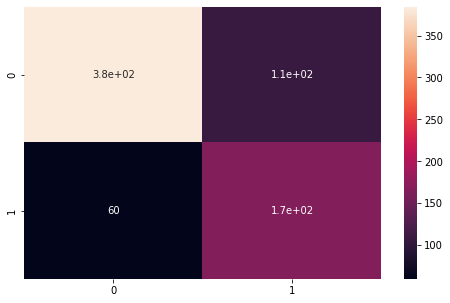

<Figure size 576x360 with 0 Axes>

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))
_ =  plt.figure(figsize=(8, 5))

logesitc Regressin Model AUC is : 0.8428393991654082


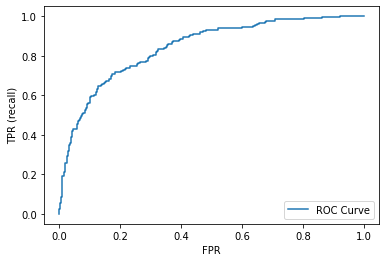

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

##### Testing lower dim number for logistic Regression

In [ ]:
pca = PCA(n_components=0.85, random_state=28)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape)
print(f"Expained variance: {np.cumsum(pca.explained_variance_)[-1]}")

(2876, 1087) (720, 1087)
Expained variance: 0.8156130691233442


In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.77      0.82       493
           1       0.60      0.74      0.66       227

    accuracy                           0.76       720
   macro avg       0.73      0.76      0.74       720
weighted avg       0.78      0.76      0.77       720



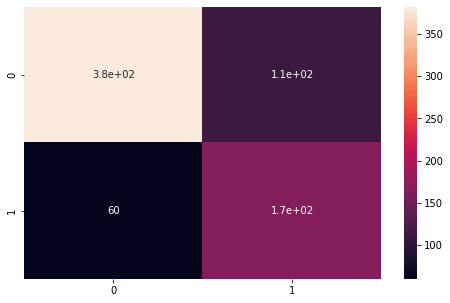

<Figure size 576x360 with 0 Axes>

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))
_ =  plt.figure(figsize=(8, 5))

logesitc Regressin Model AUC is : 0.8419815746441368


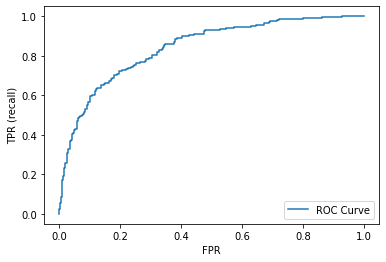

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

##### Testing logistic Regression on (2,5) char n-grams without PCA

In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       493
           1       0.59      0.77      0.67       227

    accuracy                           0.76       720
   macro avg       0.73      0.76      0.74       720
weighted avg       0.79      0.76      0.77       720



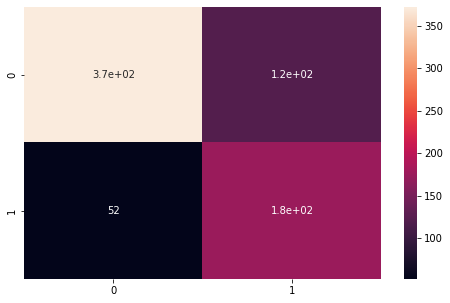

<Figure size 576x360 with 0 Axes>

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))
_ =  plt.figure(figsize=(8, 5))

logesitc Regressin Model AUC is : 0.8425802646746074


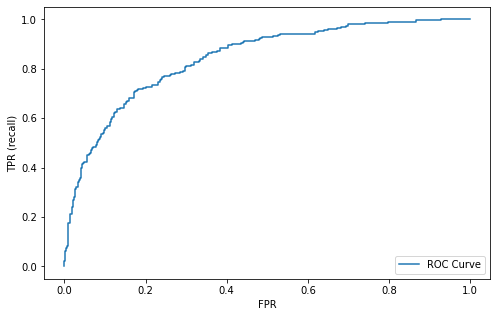

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

### Using SMOTE oversampling methode to generate train data 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())

tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(X_train).toarray()
train_vocab = len(tfidf.vocabulary_)

X_test = tfidf.transform(X_test).toarray()
test_vocab = len(tfidf.vocabulary_)

print(X_train.shape, X_test.shape)

(2876, 38217) (720, 38217)


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

print(np.unique(y_train, return_counts=True))
smote_os_X_train, smote_os_y_train = oversample.fit_resample(X_train, y_train)
print(smote_os_X_train.shape, smote_os_y_train.shape)
print(np.unique(smote_os_y_train, return_counts=True))

(array([0, 1]), array([1967,  909]))
(3934, 38217) (3934,)
(array([0, 1]), array([1967, 1967]))


In [ ]:
lr_model = LogisticRegression()
lr_model.fit(smote_os_X_train, smote_os_y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       493
           1       0.63      0.70      0.67       227

    accuracy                           0.78       720
   macro avg       0.74      0.76      0.75       720
weighted avg       0.79      0.78      0.78       720



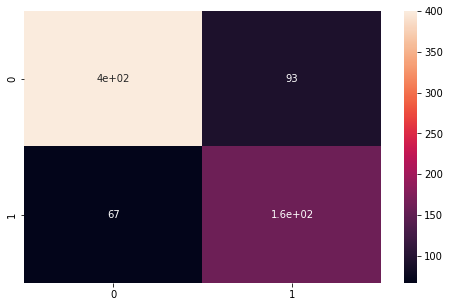

<Figure size 576x360 with 0 Axes>

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))
_ =  plt.figure(figsize=(8, 5))

logesitc Regressin Model AUC is : 0.8415347910393081


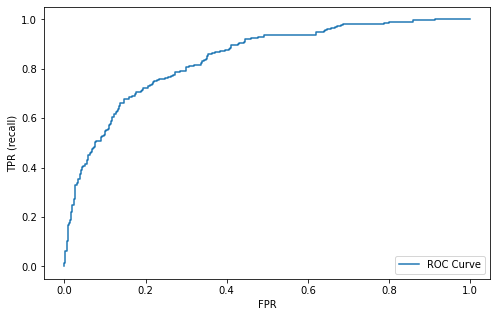

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

### We user our best model yet (LogisticRegression) to predict label for unlabelled data

In [ ]:
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(labeled_data.text.to_numpy()).toarray()
y_train = labeled_data.label.to_numpy()

X_test = tfidf.transform(unlabeled_data.text.to_numpy()).toarray()

print(X_train.shape, X_test.shape)

(3596, 43514) (45755, 43514)


##### Don't Have enught memory to performe PCA

In [ ]:
pca = PCA(n_components=0.9, random_state=28)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
print(np.unique(y_train, return_counts=True))
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

(array([0, 1]), array([2460, 1136]))
{0: 0.7308943089430894, 1: 1.5827464788732395}


In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_pred_proba = lr_model.predict_proba(X_test)

##### Only taking the comments we are most confident at

In [ ]:
lr_labels = []
for i in range(len(lr_pred_proba)):
  if lr_pred_proba[i][1] > 0.8:
    lr_labels.append(1)
  elif lr_pred_proba[i][0] > 0.8:
    lr_labels.append(0)
  else :lr_labels.append(-1)

In [ ]:
unlabeled_data.text.iloc[0]

'باسلام آقامن ازوقتی خودموشناختم مشتری بانک صادرات جاری انداز وولی امروزازصبح تاحالانتونستم توبرنامه صاپ ثبتنام خداوکیلی'

In [ ]:
unlabeled_data['lr_predicted_labels'] = lr_labels
unlabeled_data.to_csv("/content/drive/MyDrive/Cafe_Bazar/unlabelled_with_lr_labells.csv")

In [ ]:
unlabeled_data_with_lr_labelss = pd.read_csv("/content/drive/MyDrive/Cafe_Bazar/unlabelled_with_lr_labells.csv", index_col=0)
print(10 * '*' + str(unlabeled_data_with_lr_labelss.shape) + 10 * '*')
unlabeled_data_with_lr_labelss.head()

**********(45755, 2)**********


,text,lr_predicted_labels
id,,
135828912,باسلام آقامن ازوقتی خودموشناختم مشتری بانک صاد...,-1
135785334,سلام بچه میشه رفیقامون بازی بازی,-1
135166948,سلام سفارش فروشنده ارسال میشه هزینه میشه دجی ک...,-1
135727408,سلام پول پیام سکه بردارید اه ممنون,-1
135362055,افول آپدیت نمیدن اونم آپدیت بیهوده تازگیا اندر...,-1


In [ ]:
unlabeled_data_with_lr_labelss = unlabeled_data_with_lr_labelss[unlabeled_data_with_lr_labelss.lr_predicted_labels != -1]
print(10 * '*' + str(unlabeled_data_with_lr_labelss.shape) + 10 * '*')
print(unlabeled_data_with_lr_labelss.lr_predicted_labels.value_counts())
unlabeled_data_with_lr_labelss.head()

**********(12511, 2)**********
0    8815
1    3696
Name: lr_predicted_labels, dtype: int64


,text,lr_predicted_labels
id,,
135204943,رساند#رسان هنگ,1
135422855,ریلز آندروید فعال نمیشه,1
135436288,بازی بدی نصب,0
135738638,عالیه اونایی میگن نمیاره بافیلترشکن وارد شین م...,1
135050683,تلویزیون دوو رونداشت خبرته اینهمه تبلیغ حذف میشود,1


### Now we Use our newly labelled data and try to increase our models performance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))


print(f'new train data shape for semi_supervised learning : {X_train.shape}')
print(f'new train label shape for semi_supervised learning : {y_train.shape}')

print(f'new validation data shape for semi_supervised learning : {X_test.shape}')
print(f'new validation label shape for semi_supervised learning : {y_test.shape}')

new train data shape for semi_supervised learning : (15387,)
new train label shape for semi_supervised learning : (15387,)
new validation data shape for semi_supervised learning : (720,)
new validation label shape for semi_supervised learning : (720,)


### FastText

In [ ]:
ft_train_data = pd.DataFrame()
ft_train_data['label'] = y_train
ft_train_data['text'] = X_train
ft_train_data['label'] = "__label__" + ft_train_data['label'].astype('str')
ft_train_data['fasttext_input'] = ft_train_data['label'] + ' ' + ft_train_data['text'] 
print(ft_train_data.shape)
ft_train_data.head()

(15387, 3)


,label,text,fasttext_input
0,__label__0,برنامه خوبی ممنون سازندش digitتا ستاره کمه,__label__0 برنامه خوبی ممنون سازندش digitتا ست...
1,__label__1,سلام نقشه قبله نما صبا قید خلیج عرب لطفآ سریعآ...,__label__1 سلام نقشه قبله نما صبا قید خلیج عرب...
2,__label__0,اثلا بدرد نمیخوره ستاره میدم,__label__0 اثلا بدرد نمیخوره ستاره میدم
3,__label__0,نسبت کارایی‌ها,__label__0 نسبت کارایی‌ها
4,__label__0,بازی خوبیه ایکس لیندسی رفتن سمت کالاف بهتره,__label__0 بازی خوبیه ایکس لیندسی رفتن سمت کال...


In [ ]:
ft_test_data = pd.DataFrame()
ft_test_data['label'] = y_test
ft_test_data['text'] = X_test
ft_test_data['label'] = "__label__" + ft_test_data['label'].astype('str')
ft_test_data['fasttext_input'] = ft_test_data['label'] + ' ' + ft_test_data['text'] 
print(ft_test_data.shape)
ft_test_data.head()

(720, 3)


,label,text,fasttext_input
0,__label__0,سلام مسول خواهشن کرایهانظربکنید کرایه پاینه کر...,__label__0 سلام مسول خواهشن کرایهانظربکنید کرا...
1,__label__0,عالی فقد ماشین آخرو بازنمیکن,__label__0 عالی فقد ماشین آخرو بازنمیکن
2,__label__1,من نمیدونم چجوری راش بندازم,__label__1 من نمیدونم چجوری راش بندازم
3,__label__0,برنامه خوبی اینترنتم میبره رایگان سازندش خدا ر...,__label__0 برنامه خوبی اینترنتم میبره رایگان س...
4,__label__0,بلا سر اوردین قبلنا نظرمن همون نسخه قدیم بهتره,__label__0 بلا سر اوردین قبلنا نظرمن همون نسخه...


In [ ]:
ft_train_data.to_csv("comment.train", columns=['fasttext_input'], index=False, header=False)
ft_test_data.to_csv("comment.test", columns=['fasttext_input'], index=False, header=False)

In [ ]:
ft_model = fasttext.train_supervised(input='comment.train', epoch=20, lr=0.01)
ft_model.test("comment.test")

(720, 0.7736111111111111, 0.7736111111111111)

In [ ]:
ft_test_data['ft_label'] = ft_test_data.text.apply(lambda x : ft_model.predict(x)[0][0])
ft_test_data['ft_label_prob'] = ft_test_data.text.apply(lambda x : ft_model.predict(x)[1][0] if ft_model.predict(x)[0][0] == '__label__1' else  1-ft_model.predict(x)[1][0])
ft_test_data['ft_label'] = ft_test_data.ft_label.apply(lambda x : 1 if x=='__label__1' else 0)
ft_test_data.head()

,label,text,fasttext_input,ft_label,ft_label_prob
0,__label__0,سلام مسول خواهشن کرایهانظربکنید کرایه پاینه کر...,__label__0 سلام مسول خواهشن کرایهانظربکنید کرا...,1,0.533965
1,__label__0,عالی فقد ماشین آخرو بازنمیکن,__label__0 عالی فقد ماشین آخرو بازنمیکن,0,0.119799
2,__label__1,من نمیدونم چجوری راش بندازم,__label__1 من نمیدونم چجوری راش بندازم,0,0.394120
3,__label__0,برنامه خوبی اینترنتم میبره رایگان سازندش خدا ر...,__label__0 برنامه خوبی اینترنتم میبره رایگان س...,0,0.024046
4,__label__0,بلا سر اوردین قبلنا نظرمن همون نسخه قدیم بهتره,__label__0 بلا سر اوردین قبلنا نظرمن همون نسخه...,0,0.145605


              precision    recall  f1-score   support

           0       0.82      0.84      0.83       484
           1       0.66      0.63      0.65       236

    accuracy                           0.77       720
   macro avg       0.74      0.74      0.74       720
weighted avg       0.77      0.77      0.77       720



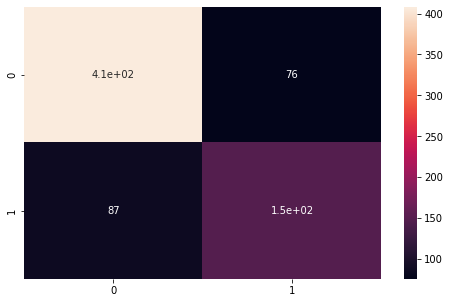

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,   ft_test_data.ft_label), annot=True)
print(classification_report(y_test.reshape(-1),   ft_test_data.ft_label))

logesitc Regressin Model AUC is : 0.8216705771116403


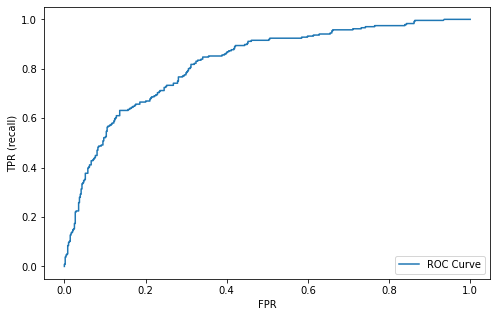

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, ft_test_data['ft_label_prob'])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

### ML models

#### Again We use Word level Vectorizer first

In [ ]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(15387, 14892) (720, 14892)


In [ ]:
print(np.unique(y_train, return_counts=True))
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

(array([0, 1]), array([10791,  4596]))
{0: 0.7129552404781763, 1: 1.6739556135770235}


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), BalancedRandomForestClassifier(class_weight=class_weights)]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.6651718983557549, f1_weighted:0.6727277545971764

Model: KNeighborsClassifier, Best params: {}
acc:0.7547280171573406, f1_weighted:0.6799666514770962

Model: RandomForestClassifier, Best params: {}
acc:0.9526223435367518, f1_weighted:0.9530207742087152

Model: SGDClassifier, Best params: {}
acc:0.956391759277312, f1_weighted:0.9570664526444391

Model: LogisticRegression, Best params: {}
acc:0.9466432702931046, f1_weighted:0.9482842278340451

Model: BalancedRandomForestClassifier, Best params: {}
acc:0.9507376356664716, f1_weighted:0.9517422998491556



In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [RandomForestClassifier(class_weight=class_weights)]

rf_params = {
    
    'n_estimators' : [100, 200, 10],
    'max_depth' : [3, 10, 100],
    'min_samples_split': [2, 10]
}

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid=rf_params, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: RandomForestClassifier, Best params: {'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 100}
acc:0.9534672125820499, f1_macro:0.9465667468975871



In [ ]:
rf_model = LogisticRegression(class_weight=class_weights)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       484
           1       0.56      0.73      0.64       236

    accuracy                           0.73       720
   macro avg       0.71      0.73      0.71       720
weighted avg       0.75      0.73      0.73       720



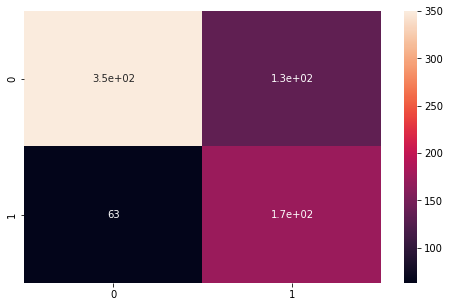

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True)
print(classification_report(y_test.reshape(-1), rf_preds))

logesitc Regressin Model AUC is : 0.8274136783863287


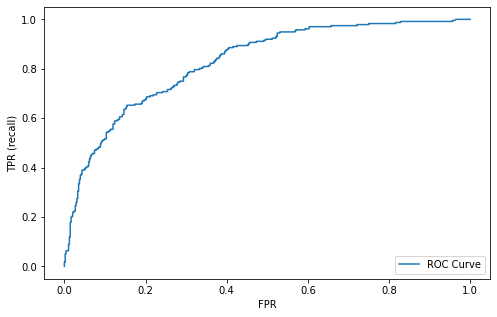

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### we can use a PCA Here

In [ ]:
pca = PCA(n_components=0.9)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)
print(f"Expained variance: {np.cumsum(pca.explained_variance_)[-1]}")

(15387, 4179) (720, 4179)
Expained variance: 0.8757280990586068


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), BalancedRandomForestClassifier(class_weight=class_weights)]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.4095015272632742, f1_macro:0.3880650704311419

Model: KNeighborsClassifier, Best params: {}
acc:0.7611620198869176, f1_macro:0.5871564434439961

Model: RandomForestClassifier, Best params: {}
acc:0.9084291934750114, f1_macro:0.885313878777222

Model: SGDClassifier, Best params: {}
acc:0.9597062455319425, f1_macro:0.952581255010247

Model: LogisticRegression, Best params: {}
acc:0.9469032299993501, f1_macro:0.941133907172412

Model: BalancedRandomForestClassifier, Best params: {}
acc:0.9231819068044453, f1_macro:0.9140255375580767



In [ ]:
sgd_model = SGDClassifier(class_weight=class_weights)
sgd_model.fit(X_train, y_train)
sgd_preds = sgd_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       484
           1       0.59      0.72      0.65       236

    accuracy                           0.74       720
   macro avg       0.72      0.74      0.72       720
weighted avg       0.76      0.74      0.75       720



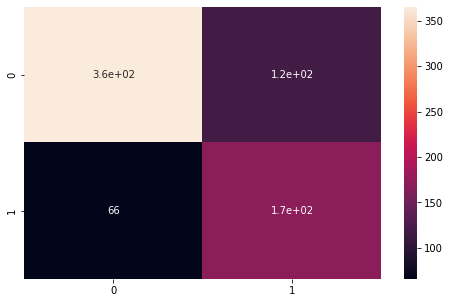

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, sgd_preds), annot=True)
print(classification_report(y_test.reshape(-1), sgd_preds))

### word n-gram level vectorizing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))


tfidf = TfidfVectorizer(ngram_range=(2, 2))

X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(15387, 61398) (720, 61398)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), BalancedRandomForestClassifier()]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.8946054509928945, f1_weighted:0.89412852572337

Model: KNeighborsClassifier, Best params: {}
acc:0.5893080890564654, f1_weighted:0.4371207069509561

Model: RandomForestClassifier, Best params: {}
acc:0.8255011085445209, f1_weighted:0.8104874325228293

Model: SGDClassifier, Best params: {}
acc:0.8421357024228383, f1_weighted:0.830512495368958

Model: LogisticRegression, Best params: {}
acc:0.7985103321566916, f1_weighted:0.7780882198464005

Model: BalancedRandomForestClassifier, Best params: {}
acc:0.8319381094932767, f1_weighted:0.817776499039073



### Char n-gram

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))


print(f'new train data shape for semi_supervised learning : {X_train.shape}')
print(f'new train label shape for semi_supervised learning : {y_train.shape}')

print(f'new validation data shape for semi_supervised learning : {X_test.shape}')
print(f'new validation label shape for semi_supervised learning : {y_test.shape}')

new train data shape for semi_supervised learning : (15387,)
new train label shape for semi_supervised learning : (15387,)
new validation data shape for semi_supervised learning : (720,)
new validation label shape for semi_supervised learning : (720,)


In [ ]:
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,2))

X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(15387, 1762) (720, 1762)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier(scale_pos_weight=2)]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.48462988236823296, f1_macro:0.4653239564224619

Model: KNeighborsClassifier, Best params: {}
acc:0.8485734711119776, f1_macro:0.7931734609895659

Model: RandomForestClassifier, Best params: {}
acc:0.949762786768051, f1_macro:0.941730246253974

Model: SGDClassifier, Best params: {}
acc:0.9539221420679794, f1_macro:0.9478320183312451

Model: LogisticRegression, Best params: {}
acc:0.9512575550789628, f1_macro:0.9454073638856247

Model: XGBClassifier, Best params: {}
acc:0.9456684213946839, f1_macro:0.9379823952921735



In [ ]:
sgd_model = SGDClassifier(class_weight=class_weights)
sgd_model.fit(X_train, y_train)
sgd_preds = sgd_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       484
           1       0.60      0.73      0.66       236

    accuracy                           0.75       720
   macro avg       0.72      0.74      0.73       720
weighted avg       0.77      0.75      0.75       720



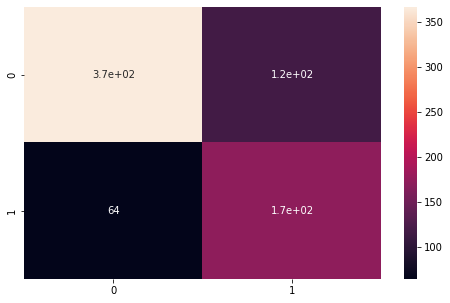

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, sgd_preds), annot=True)
print(classification_report(y_test.reshape(-1), sgd_preds))

#### PCA

In [ ]:
pca = PCA(n_components=0.9)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)
print(X_train.shape, X_test.shape)

(15387, 329) (720, 329)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier(scale_pos_weight=2)]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.7636966270228115, f1_macro:0.7432102053495439

Model: KNeighborsClassifier, Best params: {}
acc:0.9082342236953272, f1_macro:0.8826310221611834

Model: RandomForestClassifier, Best params: {}
acc:0.929225969974654, f1_macro:0.9134805086976939

Model: SGDClassifier, Best params: {}
acc:0.9535971924351726, f1_macro:0.9479519217380915

Model: LogisticRegression, Best params: {}
acc:0.9504126860336649, f1_macro:0.9445037585716345

Model: XGBClassifier, Best params: {}
acc:0.9425489049197374, f1_macro:0.9348961602244797



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       484
           1       0.57      0.77      0.65       236

    accuracy                           0.73       720
   macro avg       0.72      0.74      0.72       720
weighted avg       0.77      0.73      0.74       720



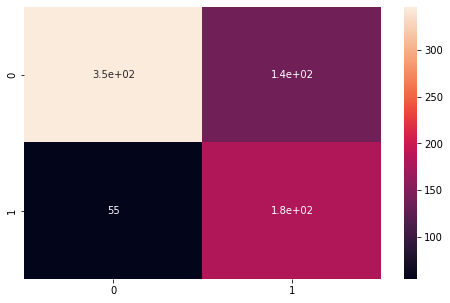

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.820860764812999


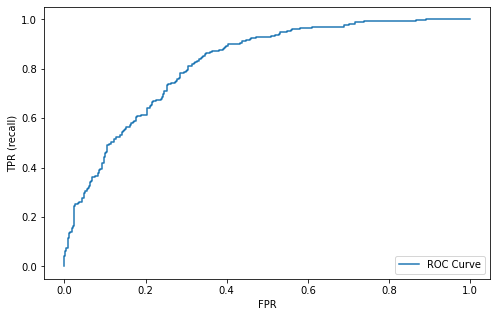

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))


tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(1,2))

X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(15387, 1892) (720, 1892)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier(scale_pos_weight=2)]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.4396568531877559, f1_macro:0.42078409571417685

Model: KNeighborsClassifier, Best params: {}
acc:0.935854942483915, f1_macro:0.9250537904544407

Model: RandomForestClassifier, Best params: {}
acc:0.9478130889712094, f1_macro:0.9392074049281502

Model: SGDClassifier, Best params: {}
acc:0.9508026255930332, f1_macro:0.9455752123034443

Model: LogisticRegression, Best params: {}
acc:0.9490478975758757, f1_macro:0.9432427909709201

Model: XGBClassifier, Best params: {}
acc:0.9457334113212452, f1_macro:0.938249101671283



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))

tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,3))

X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(15387, 12197) (720, 12197)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), XGBClassifier(scale_pos_weight=2)]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.6179242217456294, f1_macro:0.6102994300180986

Model: KNeighborsClassifier, Best params: {}
acc:0.7902125170598557, f1_macro:0.6652122189790681

Model: RandomForestClassifier, Best params: {}
acc:0.9538571521414182, f1_macro:0.9464941281614055

Model: SGDClassifier, Best params: {}
acc:0.9606810944303633, f1_macro:0.9551896594390721

Model: LogisticRegression, Best params: {}
acc:0.9535322025086111, f1_macro:0.9477669375362088

Model: XGBClassifier, Best params: {}
acc:0.9474881393384026, f1_macro:0.9401034155774939



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.75      0.80       484
           1       0.60      0.78      0.68       236

    accuracy                           0.76       720
   macro avg       0.74      0.76      0.74       720
weighted avg       0.78      0.76      0.76       720



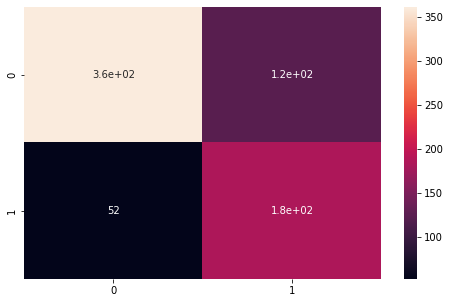

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.838449012466732


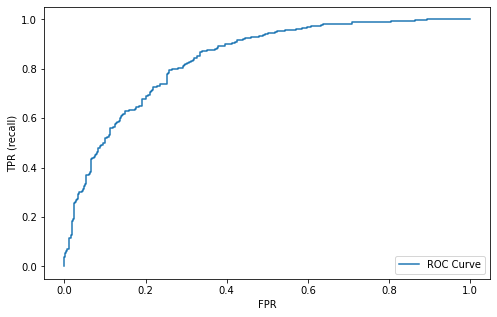

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Using SMOTE for over sampling the training data

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

print(np.unique(y_train, return_counts=True))
smote_os_X_train, smote_os_y_train = oversample.fit_resample(X_train, y_train)
print(smote_os_X_train.shape, smote_os_y_train.shape)
print(np.unique(smote_os_y_train, return_counts=True))

(array([0, 1]), array([10791,  4596]))
(21582, 12197) (21582,)
(array([0, 1]), array([10791, 10791]))


In [ ]:
lr_model = LogisticRegression()
lr_model.fit(smote_os_X_train, smote_os_y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       484
           1       0.62      0.73      0.67       236

    accuracy                           0.76       720
   macro avg       0.74      0.75      0.74       720
weighted avg       0.78      0.76      0.77       720



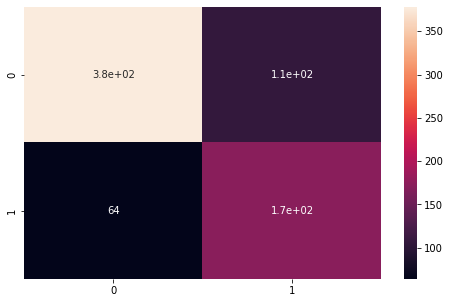

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.8397184479618994


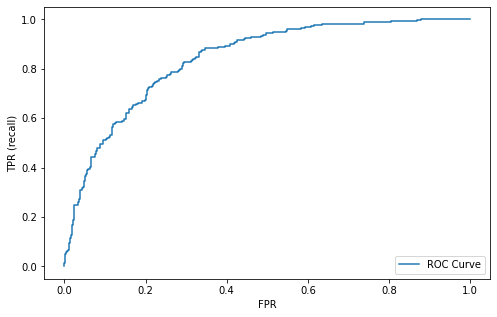

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(), SGDClassifier()),
          LogisticRegression(), XGBClassifier()]

cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy")
    res = gridcv.fit(smote_os_X_train, smote_os_y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.8581688444073765, f1_macro:0.8578566472021842

Model: KNeighborsClassifier, Best params: {}
acc:0.8869891576313594, f1_macro:0.8854827183453549

Model: RandomForestClassifier, Best params: {}
acc:0.9691872857010472, f1_macro:0.9691675083636907

Model: SGDClassifier, Best params: {}
acc:0.9630710777499768, f1_macro:0.9627278461167191

Model: LogisticRegression, Best params: {}
acc:0.9592252803261978, f1_macro:0.9588004566411464

Model: XGBClassifier, Best params: {}
acc:0.9617737003058103, f1_macro:0.9617108640618633



In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(smote_os_X_train, smote_os_y_train)
rf_preds = rf_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       484
           1       0.62      0.68      0.65       236

    accuracy                           0.76       720
   macro avg       0.73      0.74      0.73       720
weighted avg       0.77      0.76      0.76       720



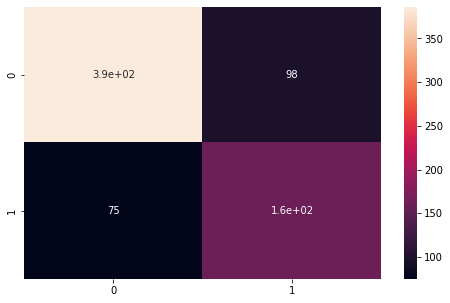

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  rf_preds), annot=True)
print(classification_report(y_test.reshape(-1),  rf_preds))

Random Forest Model AUC is : 0.8076542582994817


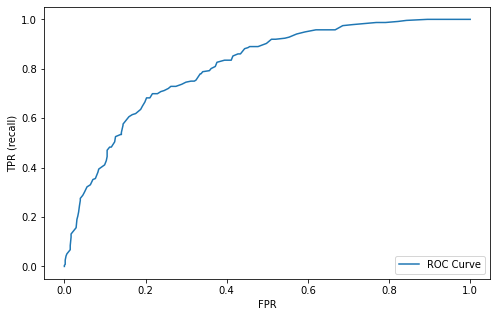

In [ ]:
_ =  plt.figure(figsize=(8, 5))

fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f'Random Forest Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

### Neural network

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))

In [ ]:
comment_tokens = Tokenizer(num_words=2000, oov_token='OOV')
comment_tokens.fit_on_texts(X_train)
X_train = np.array(comment_tokens.texts_to_sequences(X_train), dtype=object)
X_test = np.array(comment_tokens.texts_to_sequences(X_test), dtype=object)

word_index = comment_tokens.word_index
vocab = np.array(list(word_index.keys()))
vocab_size = len(vocab)
print("Number fo Unique Tokens is : ", vocab_size)

Number fo Unique Tokens is :  15161


Most Common Tokens are :  OOV عالی بازی نصب ستاره num برنامه سلام عالیه نمیشه ممنون داد ده سازندش کمه میشه خوبه دست درد سازنده


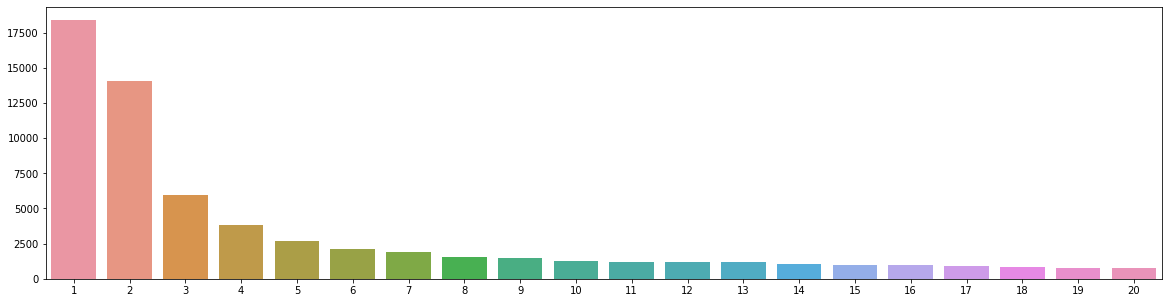

In [ ]:
all_tokens = np.array([token for comment in X_train for token in  comment])
values, counts = np.unique(all_tokens, return_counts=True)
top_values = values[:20]
top_vlaues_counts = counts[:20]
print("Most Common Tokens are : ", comment_tokens.sequences_to_texts([top_values])[0])
_ = plt.figure(figsize=(20, 5))
_ = sns.barplot(x=top_values, y=top_vlaues_counts)

In [ ]:
lengths=[]
for k in range(len(X_train)):
  lengths.append(len(X_train[k]))
pd.DataFrame(lengths, columns=['Lenghts']).describe()

,Lenghts
count,15387.000000
mean,8.457854
std,5.322105
min,0.000000
25%,5.000000
50%,7.000000
75%,11.000000
max,46.000000


train comments median lenght 7


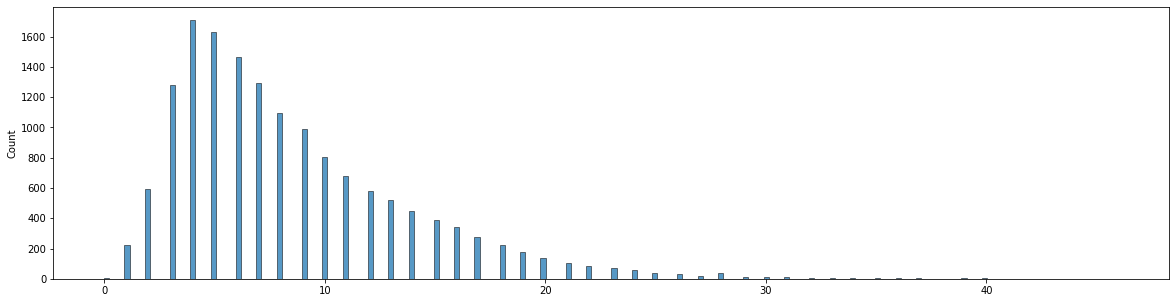

In [ ]:
train_median_len = int(np.percentile(lengths, 50))
print(f'train comments median lenght {train_median_len}')
plt.figure(figsize=(20, 5))
_ = sns.histplot(lengths, bins=200)

In [ ]:
max_length = train_median_len
trunc_type = 'post'
padding_type = 'post'
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
print(np.unique(y_train, return_counts=True))
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

(array([0, 1]), array([10791,  4596]))
{0: 0.7129552404781763, 1: 1.6739556135770235}


In [ ]:
embed_size = 5
num_oov_buckets = 10
GRU_model = keras.models.Sequential([
    keras.layers.Embedding(2000 + num_oov_buckets, embed_size,
    input_shape=[train_median_len]),
    keras.layers.GRU(4, dropout=.5),
    keras.layers.Dense(1, activation="sigmoid")
])
GRU_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 7, 5)              10050     
                                                                 
 gru_4 (GRU)                 (None, 4)                 132       
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 10,187
Trainable params: 10,187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
GRU_model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy', keras.metrics.AUC()]
                )
GRU_history = GRU_model.fit(X_train, y_train, epochs=20, verbose=1, batch_size = 32,
                    validation_split=0.1, callbacks = callbacks, class_weight=class_weights)

Epoch 1/20
433/433 [==============================] - 6s 8ms/step - loss: 0.4663 - accuracy: 0.8317 - auc_4: 0.8897 - val_loss: 0.1267 - val_accuracy: 0.9766 - val_auc_4: 0.9977
Epoch 2/20
433/433 [==============================] - 3s 6ms/step - loss: 0.2028 - accuracy: 0.9279 - auc_4: 0.9766 - val_loss: 0.0729 - val_accuracy: 0.9890 - val_auc_4: 0.9993
Epoch 3/20
433/433 [==============================] - 3s 7ms/step - loss: 0.1691 - accuracy: 0.9382 - auc_4: 0.9827 - val_loss: 0.0528 - val_accuracy: 0.9922 - val_auc_4: 0.9993
Epoch 4/20
433/433 [==============================] - 3s 6ms/step - loss: 0.1539 - accuracy: 0.9432 - auc_4: 0.9847 - val_loss: 0.0479 - val_accuracy: 0.9935 - val_auc_4: 0.9987
Epoch 5/20
433/433 [==============================] - 3s 7ms/step - loss: 0.1444 - accuracy: 0.9459 - auc_4: 0.9862 - val_loss: 0.0459 - val_accuracy: 0.9922 - val_auc_4: 0.9989
Epoch 6/20
433/433 [==============================] - 3s 6ms/step - loss: 0.1372 - accuracy: 0.9495 - auc_4: 0

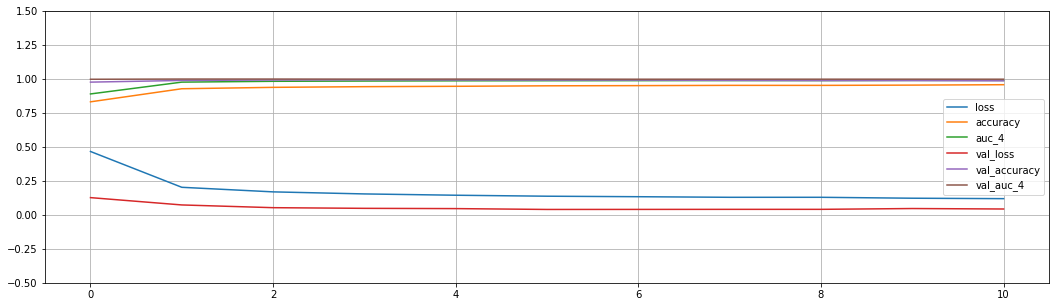

In [ ]:
pd.DataFrame(GRU_history.history).plot(figsize=(18, 5))
plt.grid(True)
plt.gca().set_ylim(-0.5, 1.5) # set the vertical range to [0-1]
plt.show()

In [ ]:
GRU_model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.7514 - auc_4: 0.8261


[0.6651602983474731, 0.7513889074325562, 0.8260566592216492]

In [ ]:
predicted_label = GRU_model.predict(X_test)
predicted_label = [1 if proba >0.5 else 0 for proba in predicted_label ]

23/23 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.73      0.77      0.75       484
           1       0.47      0.43      0.45       236

    accuracy                           0.66       720
   macro avg       0.60      0.60      0.60       720
weighted avg       0.65      0.66      0.65       720



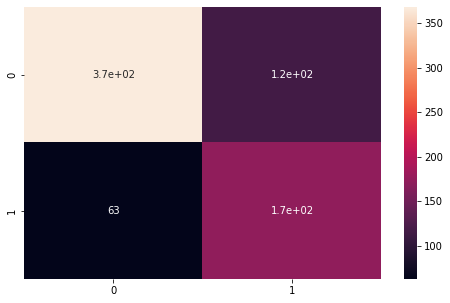

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, predicted_label), annot=True)
print(classification_report(y_test.reshape(-1),  sgd_preds))

In [ ]:
train_median_len = int(np.percentile([len(txt.split(" ")) for txt in X_train], 50))
print(f'train comments median lenght {train_median_len}')


vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=train_median_len)
text_ds = tf.data.Dataset.from_tensor_slices(X_train)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

train comments median lenght 7


In [ ]:
persain_embeding = fasttext.load_model('/content/drive/MyDrive/Persian_Nlp/classification/cc.fa.100.bin')


num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = persain_embeding.get_word_vector(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

persain_embeding=None
print(embedding_matrix.shape)

Converted 15179 words (0 misses)
(15181, 100)


In [ ]:
#creating the embedding layer

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.GRU(5)(embedded_sequences)
preds = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 100)         1518100   
                                                                 
 gru_10 (GRU)                (None, 5)                 1605      
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,519,711
Trainable params: 1,611
Non-trainable params: 1,518,100
_________________________________________________________________


In [ ]:
callbacks = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy', keras.metrics.AUC()]
                )
history = model.fit(X_train, y_train, epochs=20, verbose=1, batch_size = 32, validation_split=0.2, callbacks = callbacks, class_weight=class_weights)

Epoch 1/20
385/385 [==============================] - 6s 8ms/step - loss: 0.5157 - accuracy: 0.7339 - auc_7: 0.8466 - val_loss: 0.2450 - val_accuracy: 0.9185 - val_auc_7: 0.9746
Epoch 2/20
385/385 [==============================] - 3s 7ms/step - loss: 0.3077 - accuracy: 0.8777 - auc_7: 0.9425 - val_loss: 0.2265 - val_accuracy: 0.9233 - val_auc_7: 0.9855
Epoch 3/20
385/385 [==============================] - 3s 9ms/step - loss: 0.2794 - accuracy: 0.8911 - auc_7: 0.9523 - val_loss: 0.1634 - val_accuracy: 0.9467 - val_auc_7: 0.9903
Epoch 4/20
385/385 [==============================] - 3s 7ms/step - loss: 0.2619 - accuracy: 0.8994 - auc_7: 0.9577 - val_loss: 0.1649 - val_accuracy: 0.9454 - val_auc_7: 0.9926
Epoch 5/20
385/385 [==============================] - 2s 6ms/step - loss: 0.2491 - accuracy: 0.9026 - auc_7: 0.9614 - val_loss: 0.1266 - val_accuracy: 0.9594 - val_auc_7: 0.9941
Epoch 6/20
385/385 [==============================] - 2s 6ms/step - loss: 0.2381 - accuracy: 0.9081 - auc_7: 0

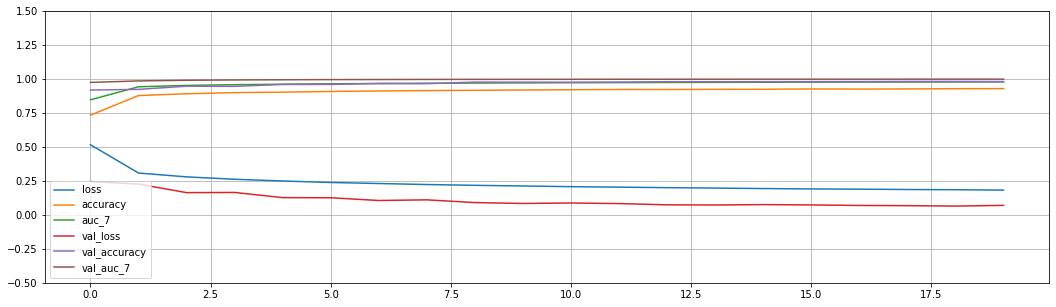

In [ ]:
pd.DataFrame(history.history).plot(figsize=(18, 5))
plt.grid(True)
plt.gca().set_ylim(-0.5, 1.5) # set the vertical range to [0-1]
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.6335 - accuracy: 0.7361 - auc_7: 0.8093


[0.6334845423698425, 0.7361111044883728, 0.8093000650405884]

# New Approach Using Valid Charachters

In [7]:
persian_alphabet = [' ', 'ا', 'ی', 'ر', 'د', 'ن', 'و', 'ه', 'م', 'ت', 'ب', 'س', 'ک', 'ش', 'ل', 'ز',
                   'خ', 'گ', 'ف', 'ق', 'پ', 'آ', 'ج', 'ع', 'ح', 'چ', 'ص', 'ط', 'غ', 'ض', 'ذ', 'ظ', 'ث', 'ژ']

persian_numbers = ['۲', '۵', '۳', '۴', '۱', '۶', '۸', '۹', '۷', '۰']

lower_english_alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p','q', 'r', 's', 't', 'w', 'x', 'y', 'z', 'u']

capital_english_alphabet = [x.upper() for x in lower_english_alphabet]

english_numbers = ['1', '2','3', '4' , '0', '9', '8', '7', '6', '5']

In [8]:
translate_dict = {
          ord('ة') : ord('ه'),
			    ord('ك') : ord('ک'),
          ord('ي') : ord('ی'),
          ord('أ') : ord('ا'),
          ord('ە') : ord('ه'),
			    ord('ہ') : ord('ه'),
          ord('ے') : ord('ی'),
          ord('ڪ') : ord('ک'),
          ord('٦') : ord('۶'),
			    ord('٤') : ord('۴'),
          ord('٥') : ord('۵'),
          ord('ۻ') : ord('ض'),
			    ord('ڋ') : ord('د'),
          ord('ڕ') : ord('ر'),
          ord('ٻ') : ord('ب'),
          ord('ڑ') : ord('ر'),
			    ord('ئ') : ord('ی'),
          ord('ۀ') : ord('ه'),
          }
def clean_persian_text(text, allow_en=False, allow_eng_num=False, allow_fa_num=True):
  text = text.lower().strip()
  text = Normalizer().normalize(text)
  valid_chars = persian_alphabet + persian_numbers + lower_english_alphabet + english_numbers
  text.translate(translate_dict)
  text = ''.join([char for char in text if char in valid_chars])
  return text

In [9]:
!git clone https://github.com/kharazi/persian-stopwords.git

with open("/content/persian-stopwords/persian", "r") as f:
  content = f.read()
  stopwords_p = content.split("\n")
  stopwords_p = stopwords_p[:-1]        
with open("/content/persian-stopwords/short", "r") as f:
  content = f.read()
  stopwords_s = content.split("\n")
  stopwords_s = stopwords_s[:-1]

with open("/content/persian-stopwords/verbal", "r") as f:
  content = f.read()
  stopwords_v = content.split("\n")
  stopwords_v = stopwords_v[:-1]

with open("/content/persian-stopwords/nonverbal", "r") as f :
  content = f.read()
  stopwords_nv = content.split("\n")
  stopwords_nv = stopwords_nv[:-1]
  

fa_stopwords = set(stopwords_p + stopwords_s + stopwords_v + stopwords_nv)

Cloning into 'persian-stopwords'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 51 (delta 7), reused 5 (delta 5), pack-reused 42
Unpacking objects: 100% (51/51), 34.96 KiB | 1.75 MiB/s, done.


In [10]:
hzm_tokenize = WordTokenizer().tokenize
hzm_lemmaitze = Lemmatizer(joined_verb_parts=False).lemmatize


def my_toknizer(text):
  text_tokens = hzm_tokenize(text)
  clean_tokens = [hzm_lemmaitze(token) for token in text_tokens if token not in fa_stopwords]
  return ' '.join(clean_tokens)


In [11]:
print(f'before clean : {labeled_data.text.iloc[0]}')
print(f'before clean : {unlabeled_data.text.iloc[0]}')

labeled_data.text = labeled_data.text.apply(lambda x : clean_persian_text(x))
unlabeled_data.text = unlabeled_data.text.apply(lambda x : clean_persian_text(x))

labeled_data.text = labeled_data.text.apply(lambda x : my_toknizer(x))
unlabeled_data.text = unlabeled_data.text.apply(lambda x : my_toknizer(x))

print(f'after clean : {labeled_data.text.iloc[0]}')
print(f'after clean : {unlabeled_data.text.iloc[0]}')

before clean : عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی خیلی خیلی خیلی خیلی خیلی ممنونم که این بازی رو ساختید😍😍😍😍😍😍😍🤩🤩🤩🤩
before clean : باسلام آقامن ازوقتی خودموشناختم مشتری بانک صادرات بودم ح جاری پس انداز و....ولی امروزازصبح تاحالانتونستم توبرنامه صاپ ثبت‌نام بکنم خداوکیلی
after clean : عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی عالی ممنون بازی ساخت#ساز
after clean : باسلام آقامن ازوقتی خودموشناختم مشتری بانک صادرات جاری انداز امروزازصبح تاحالانتونستم توبرنامه صاپ ثبتنام خداوکیلی


In [ ]:
comment_tokens = Tokenizer(char_level=True)
comment_tokens.fit_on_texts(np.concatenate([unlabeled_data.text, labeled_data.text]))
vocab = np.array(list(comment_tokens.word_index.keys()))
vocab

array([' ', 'ا', 'ی', 'ن', 'ر', 'م', 'ه', 'د', 'ب', 'و', 'ت', 'ل', 'س',
       'ش', 'ز', 'ک', 'ع', 'خ', 'ف', 'گ', 'پ', 'ص', 'ق', '#', 'ح', 'ج',
       'چ', '۰', 'ط', 'ض', 'آ', 'ظ', '۱', 'ذ', 'غ', '۲', '۵', 'ث', '۳',
       '۴', '_', 'a', 'ژ', '۹', '۶', 'e', '۸', 'o', '۷', 's', 'i', 'n',
       'r', 't', 'p', 'l', 'm', 'h', 'd', 'g', 'c', 'u', 'y', 'k', 'b',
       'f', 'x', 'w', 'z', 'j', 'q'], dtype='<U1')

### Usin Fasttext with new approache

In [ ]:
train, test = train_test_split(labeled_data, test_size = 0.2, random_state=42, stratify=labeled_data.label)

print(f'Train data shape for semi_supervised learning : {train.shape}')
print(f'Test data shape for semi_supervised learning : {test.shape}')

Train data shape for semi_supervised learning : (2876, 2)
Test data shape for semi_supervised learning : (720, 2)


In [ ]:
ft_train_data = pd.DataFrame()
ft_train_data['label'] = "__label__" + train['label'].astype('str')
ft_train_data['fasttext_input'] =ft_train_data['label'] + ' ' + train['text'] 
print(ft_train_data.shape)
ft_train_data.head()

(2876, 2)


,label,fasttext_input
id,,
132032925,__label__0,__label__0 سلام ممنون سازندش ممنون پدر شادی خشن
131705151,__label__0,__label__0 عالی هرکی موافقه لایک کنه
94049052,__label__1,__label__1 عالی منقضی شده دیلیت بشه عالی میشه
131658611,__label__0,__label__0 تعقیرات چرت پاک درد خورد#خور
133253429,__label__0,__label__0 بدونه چونه زدن قیمت سفر


In [ ]:
ft_test_data = pd.DataFrame()
ft_test_data['label'] = "__label__" + test['label'].astype('str')
ft_test_data['fasttext_input'] =ft_test_data['label'] + ' ' + test['text']
ft_test_data['text'] =  test['text']
print(ft_test_data.shape)
ft_test_data.head()

(720, 3)


,label,fasttext_input,text
id,,,
131607001,__label__1,__label__1 ببینید واتساپ بدرد نمیخوره ستاره بر...,ببینید واتساپ بدرد نمیخوره ستاره براش خییییلی ...
131238843,__label__0,__label__0 ۲۰ درصد فالورها ایران هستن,۲۰ درصد فالورها ایران هستن
131892947,__label__0,__label__0 برنامه خوبی راضی لینکش دوستام فرستا...,برنامه خوبی راضی لینکش دوستام فرستاد#فرست ماه ...
131432520,__label__0,__label__0 عالی دکان شاد نی شند بگرید بچه,عالی دکان شاد نی شند بگرید بچه
131844240,__label__1,__label__1 کار کرد#کن گوش نوکیا تلویزیون مارک ...,کار کرد#کن گوش نوکیا تلویزیون مارک مارشال


In [ ]:
ft_train_data.to_csv("comment.train", columns=['fasttext_input'], index=False, header=False)
ft_test_data.to_csv("comment.test", columns=['fasttext_input'], index=False, header=False)

In [ ]:
ft_model = fasttext.train_supervised(input='comment.train', epoch=50, lr=0.01)
ft_model.test("comment.test")

(720, 0.7777777777777778, 0.7777777777777778)

In [ ]:
ft_test_data['ft_label'] = ft_test_data.text.apply(lambda x : ft_model.predict(x)[0][0])
ft_test_data['ft_label'] = ft_test_data.ft_label.apply(lambda x : 1 if x=='__label__1' else 0)
ft_test_data.head()

,label,fasttext_input,text,ft_label
id,,,,
131607001,__label__1,__label__1 ببینید واتساپ بدرد نمیخوره ستاره بر...,ببینید واتساپ بدرد نمیخوره ستاره براش خییییلی ...,1
131238843,__label__0,__label__0 ۲۰ درصد فالورها ایران هستن,۲۰ درصد فالورها ایران هستن,0
131892947,__label__0,__label__0 برنامه خوبی راضی لینکش دوستام فرستا...,برنامه خوبی راضی لینکش دوستام فرستاد#فرست ماه ...,0
131432520,__label__0,__label__0 عالی دکان شاد نی شند بگرید بچه,عالی دکان شاد نی شند بگرید بچه,0
131844240,__label__1,__label__1 کار کرد#کن گوش نوکیا تلویزیون مارک ...,کار کرد#کن گوش نوکیا تلویزیون مارک مارشال,1


              precision    recall  f1-score   support

           0       0.80      0.90      0.85       493
           1       0.70      0.52      0.59       227

    accuracy                           0.78       720
   macro avg       0.75      0.71      0.72       720
weighted avg       0.77      0.78      0.77       720



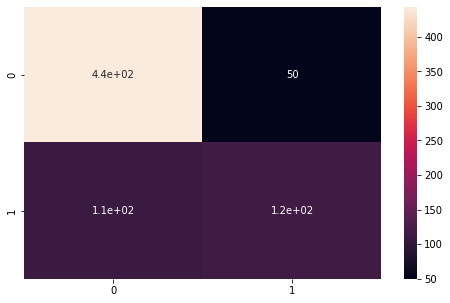

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,   ft_test_data.ft_label), annot=True)
print(classification_report(y_test.reshape(-1),   ft_test_data.ft_label))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())

print(f'train data shape for semi_supervised learning : {X_train.shape}')
print(f'train label shape for semi_supervised learning : {y_train.shape}')

print(f'validation data shape for semi_supervised learning : {X_test.shape}')
print(f'validation label shape for semi_supervised learning : {y_test.shape}')

train data shape for semi_supervised learning : (2876,)
train label shape for semi_supervised learning : (2876,)
validation data shape for semi_supervised learning : (720,)
validation label shape for semi_supervised learning : (720,)


In [ ]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(2876, 6115) (720, 6115)


In [ ]:
strategies = ["stratified", "most_frequent", "uniform"]
for strategy in strategies:
    cv_results = cross_val_score(DummyClassifier(strategy=strategy), X_train, y_train, scoring="f1_macro", cv=3)
    print(f"{strategy} strategy scores: {cv_results}")


stratified strategy scores: [0.48302654 0.50188761 0.50705049]
most_frequent strategy scores: [0.40619195 0.40619195 0.40607564]
uniform strategy scores: [0.47792265 0.49406799 0.49664577]


In [ ]:
print(np.unique(y_train, return_counts=True))
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)


(array([0, 1]), array([1967,  909]))
{0: 0.7310625317742755, 1: 1.5819581958195819}


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), SVC(), XGBClassifier(scale_pos_weight=class_weights.get(0)/class_weights.get(1))
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.4975687240899133, f1_macro:0.49593762075455405

Model: KNeighborsClassifier, Best params: {}
acc:0.6877640896811005, f1_macro:0.43049674189991655

Model: RandomForestClassifier, Best params: {}
acc:0.7513865275168476, f1_macro:0.6514086393128408

Model: SGDClassifier, Best params: {}
acc:0.7378329171755258, f1_macro:0.6843194491612238

Model: LogisticRegression, Best params: {}
acc:0.7423555039863347, f1_macro:0.7137416813915664

Model: SVC, Best params: {}
acc:0.7353965617455552, f1_macro:0.607645773583308

Model: XGBClassifier, Best params: {}
acc:0.7200988619698524, f1_macro:0.54225447513196



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       493
           1       0.58      0.69      0.63       227

    accuracy                           0.75       720
   macro avg       0.71      0.73      0.72       720
weighted avg       0.76      0.75      0.75       720



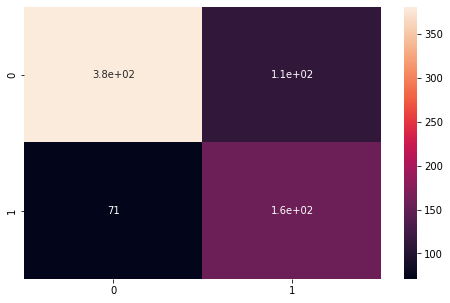

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.8032320325973319


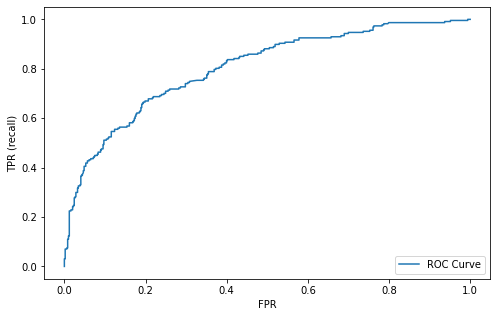

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

### char N-grams

In [ ]:
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(2876, 36058) (720, 36058)


In [ ]:
scoring = {  "accuracy":make_scorer(accuracy_score),
           "f1_macro":make_scorer(f1_score, average="macro"),}

models = [GaussianNB(), KNeighborsClassifier(), 
          RandomForestClassifier(class_weight=class_weights), SGDClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), SVC(), XGBClassifier(scale_pos_weight=class_weights.get(0)/class_weights.get(1))
          ]


cv_results = {}

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    gridcv = GridSearchCV(model, param_grid={}, scoring=scoring, cv=3, refit="accuracy", return_train_score=True)
    res = gridcv.fit(X_train, y_train)
    best_score_idx = np.argmax(res.cv_results_["mean_test_f1_macro"])
    best_accuracy = res.cv_results_["mean_test_accuracy"][best_score_idx]
    best_f1_macro = res.cv_results_["mean_test_f1_macro"][best_score_idx]
    cv_results[model_name] = res
    print(f"Model: {model_name}, Best params: {res.best_params_}\nacc:{best_accuracy}, f1_macro:{best_f1_macro}\n")

Model: GaussianNB, Best params: {}
acc:0.5538969713725516, f1_macro:0.5312406694342086

Model: KNeighborsClassifier, Best params: {}
acc:0.6867206111678325, f1_macro:0.4390816667782396

Model: RandomForestClassifier, Best params: {}
acc:0.7635595969183279, f1_macro:0.6976109521584002

Model: SGDClassifier, Best params: {}
acc:0.7548718038028189, f1_macro:0.704026775613953

Model: LogisticRegression, Best params: {}
acc:0.760089559192008, f1_macro:0.7346443784775264

Model: SVC, Best params: {}
acc:0.7642580309023477, f1_macro:0.6792901597760882

Model: XGBClassifier, Best params: {}
acc:0.7437443898516998, f1_macro:0.6208952806702661



In [ ]:
lr_model = LogisticRegression(class_weight=class_weights)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       493
           1       0.61      0.74      0.67       227

    accuracy                           0.77       720
   macro avg       0.74      0.76      0.75       720
weighted avg       0.79      0.77      0.78       720



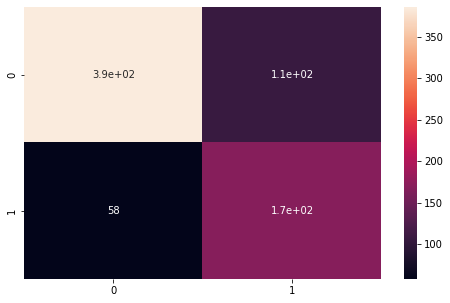

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.8433666038191062


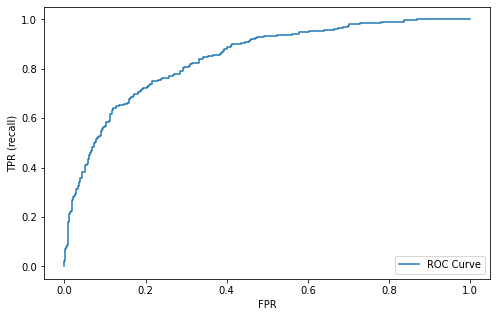

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())

tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(X_train).toarray()
train_vocab = len(tfidf.vocabulary_)

X_test = tfidf.transform(X_test).toarray()
test_vocab = len(tfidf.vocabulary_)

print(X_train.shape, X_test.shape)

(2876, 36058) (720, 36058)


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

print(np.unique(y_train, return_counts=True))
smote_os_X_train, smote_os_y_train = oversample.fit_resample(X_train, y_train)
print(smote_os_X_train.shape, smote_os_y_train.shape)
print(np.unique(smote_os_y_train, return_counts=True))

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(smote_os_X_train, smote_os_y_train)
lr_preds = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       493
           1       0.62      0.71      0.66       227

    accuracy                           0.77       720
   macro avg       0.74      0.76      0.75       720
weighted avg       0.78      0.77      0.78       720



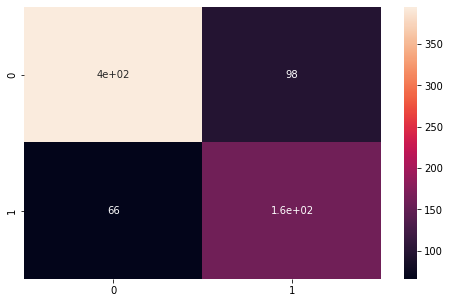

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  lr_preds), annot=True)
print(classification_report(y_test.reshape(-1),  lr_preds))

logesitc Regressin Model AUC is : 0.8446980189614963


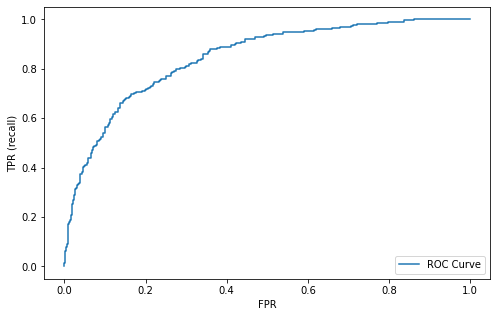

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Using Voting Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=labeled_data.label.to_numpy())
print(X_train.shape, X_test.shape)

(2876,) (720,)


In [ ]:
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

print(X_train.shape, X_test.shape)

(2876, 36058) (720, 36058)


In [17]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 18.1 MB/s eta 0:00:00


In [18]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
cat_pipeline = make_pipeline(TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5)), CatBoostClassifier(verbose=0, eval_metric="AUC", random_state=42,))
catboost_cv_result = cross_validate(cat_pipeline, X_train, y_train, cv=3, scoring=['accuracy', 'f1', "roc_auc"])

In [ ]:
catboost_cv_result

{'fit_time': array([180.71704984, 167.40697455, 164.16527295]),
 'score_time': array([0.34774947, 0.35524631, 0.38186073]),
 'test_accuracy': array([0.7632951 , 0.75391032, 0.76722338]),
 'test_f1': array([0.56092843, 0.54440154, 0.5752381 ]),
 'test_roc_auc': array([0.81194408, 0.82573654, 0.82659915])}

In [ ]:
lgbm_pipeline = make_pipeline(tfidf, LGBMClassifier(metric="auc"))
lgbm_cv_result = cross_validate(lgbm_pipeline, X_train, y_train, cv=3, scoring=['accuracy', 'f1', "roc_auc"])
lgbm_cv_result

{'fit_time': array([19.96640444, 16.41284609, 17.25766349]),
 'score_time': array([0.31578922, 0.41570306, 0.29417205]),
 'test_accuracy': array([0.75286757, 0.75912409, 0.76409186]),
 'test_f1': array([0.54510557, 0.57458564, 0.59205776]),
 'test_roc_auc': array([0.80592701, 0.82040369, 0.8157912 ])}

In [ ]:
xgboost_pipeline = make_pipeline(tfidf, XGBClassifier(eval_metric="auc",))
xgboost_cv_result = cross_validate(xgboost_pipeline, X_train, y_train, cv=3, scoring=['accuracy', 'f1', "roc_auc"])
xgboost_cv_result

{'fit_time': array([8.57623172, 6.94805074, 6.25288653]),
 'score_time': array([0.34841228, 0.40041828, 0.32930136]),
 'test_accuracy': array([0.75703858, 0.75391032, 0.76617954]),
 'test_f1': array([0.53118712, 0.51836735, 0.57414449]),
 'test_roc_auc': array([0.79523112, 0.80860853, 0.82022523])}

In [ ]:
cat_boost = CatBoostClassifier(verbose=0 )
xg_boost= XGBClassifier(verbose=0)
lgbm = LGBMClassifier(verbose=0)
lr = LogisticRegression(class_weight=class_weights)


voting_clf = VotingClassifier(estimators=[('lr', lr), ('cat', cat_boost), ('xgb', xg_boost), ('lgb', lgbm)], voting='soft')

voting_pipeline = make_pipeline(tfidf, voting_clf)

voting_cv_result = cross_validate(voting_pipeline, X_train, y_train, cv=3, scoring=['accuracy', 'f1', "roc_auc"])

voting_cv_result

{'fit_time': array([182.02754378, 180.21287465, 176.78003359]),
 'score_time': array([0.45788217, 0.4432497 , 0.46121764]),
 'test_accuracy': array([0.77685089, 0.7632951 , 0.77974948]),
 'test_f1': array([0.59160305, 0.57570093, 0.62254025]),
 'test_roc_auc': array([0.82107281, 0.83726757, 0.83718036])}

In [ ]:
voting_model = voting_pipeline
voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       493
           1       0.68      0.56      0.62       227

    accuracy                           0.78       720
   macro avg       0.75      0.72      0.73       720
weighted avg       0.77      0.78      0.77       720



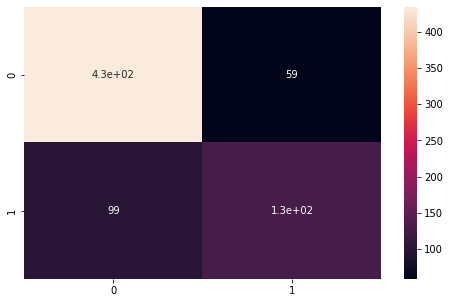

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,  voting_preds), annot=True)
print(classification_report(y_test.reshape(-1),  voting_preds))

logesitc Regressin Model AUC is : 0.8429376915584706


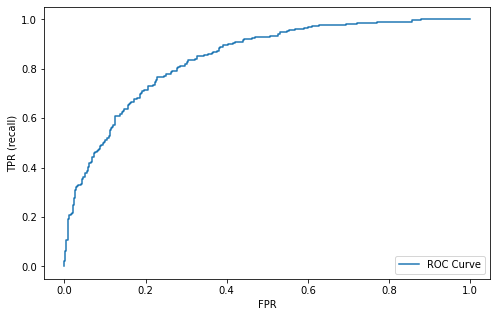

In [ ]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, voting_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)

#### Using Smote For Labelling the unlabelled Data

In [16]:
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train = tfidf.fit_transform(labeled_data.text.to_numpy()).toarray()
X_test = tfidf.transform(unlabeled_data.text.to_numpy()).toarray()

from imblearn.over_sampling import SMOTE
oversample = SMOTE()

print(np.unique(labeled_data.label.to_numpy(), return_counts=True))
smote_os_X_train, smote_os_y_train = oversample.fit_resample(X_train, labeled_data.label.to_numpy())
print(smote_os_X_train.shape, smote_os_y_train.shape)
print(np.unique(smote_os_y_train, return_counts=True))

lr_model = LogisticRegression()
lr_model.fit(smote_os_X_train, smote_os_y_train)
final_pred_probas = lr_model.predict_proba(X_test)

(array([0, 1]), array([2460, 1136]))
(4920, 40912) (4920,)
(array([0, 1]), array([2460, 2460]))


In [ ]:
lr_labels = []
for i in range(len(final_pred_probas)):
  if final_pred_probas[i][1] > 0.8:
    lr_labels.append(1)
  elif final_pred_probas[i][0] > 0.8:
    lr_labels.append(0)
  else :lr_labels.append(-1)


In [ ]:
unlabeled_data['lr_predicted_labels'] = lr_labels
unlabeled_data.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/SMOTE_unlabelled_with_lr_labells.csv")

In [12]:
unlabeled_data_with_lr_labelss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/SMOTE_unlabelled_with_lr_labells.csv", index_col=0)
print(10 * '*' + str(unlabeled_data_with_lr_labelss.shape) + 10 * '*')
unlabeled_data_with_lr_labelss.head()

**********(45755, 2)**********


,text,lr_predicted_labels
id,,
135828912,باسلام آقامن ازوقتی خودموشناختم مشتری بانک صاد...,-1
135785334,سلام بچه میشه رفیقامون بازی بازی,-1
135166948,سلام سفارش فروشنده ارسال میشه هزینه میشه دجی ک...,-1
135727408,سلام پول پیام سکه بردارید اه ممنون,-1
135362055,افول آپدیت نمیدن اونم آپدیت بیهوده تازگیا اندر...,-1


In [13]:
unlabeled_data_with_lr_labelss = unlabeled_data_with_lr_labelss[unlabeled_data_with_lr_labelss.lr_predicted_labels != -1]
print(10 * '*' + str(unlabeled_data_with_lr_labelss.shape) + 10 * '*')
print(unlabeled_data_with_lr_labelss.lr_predicted_labels.value_counts())
unlabeled_data_with_lr_labelss.head()

**********(16204, 2)**********
0    11633
1     4571
Name: lr_predicted_labels, dtype: int64


,text,lr_predicted_labels
id,,
135157105,داد#ده نصب پشیمون میشید,0
135427927,عالیه باخت#باز بهترازاین بشه,0
135204943,رساند#رسان هنگ,1
135422855,ریلز آندروید فعال نمیشه,1
135436288,بازی بدی نصب,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text.to_numpy(), labeled_data.label.to_numpy(), test_size = 0.2, random_state=42)

X_train = np.concatenate((X_train, unlabeled_data_with_lr_labelss.text))
y_train = np.concatenate((y_train, unlabeled_data_with_lr_labelss.lr_predicted_labels))


print(f'new train data shape for semi_supervised learning : {X_train.shape}')
print(f'new train label shape for semi_supervised learning : {y_train.shape}')

print(f'new validation data shape for semi_supervised learning : {X_test.shape}')
print(f'new validation label shape for semi_supervised learning : {y_test.shape}')

new train data shape for semi_supervised learning : (19080,)
new train label shape for semi_supervised learning : (19080,)
new validation data shape for semi_supervised learning : (720,)
new validation label shape for semi_supervised learning : (720,)


In [15]:
print(np.unique(y_train, return_counts=True))
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

(array([0, 1]), array([13609,  5471]))
{0: 0.7010066867514145, 1: 1.7437397185158106}


In [19]:
cat_boost = CatBoostClassifier(verbose=0 )
xg_boost= XGBClassifier(verbose=0)
lgbm = LGBMClassifier(verbose=0)
lr = LogisticRegression(class_weight=class_weights)


voting_clf = VotingClassifier(estimators=[('lr', lr), ('cat', cat_boost), ('xgb', xg_boost), ('lgb', lgbm)], voting='soft')
voting_pipeline = make_pipeline(TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5)), voting_clf)
voting_cv_result = cross_validate(voting_pipeline, X_train, y_train, cv=3, scoring=['accuracy', 'f1', "roc_auc"])
voting_cv_result

{'fit_time': array([553.38453484, 578.11566758, 567.85925841]),
 'score_time': array([2.26311135, 2.22264886, 2.24037147]),
 'test_accuracy': array([0.89606918, 0.99827044, 0.99968553]),
 'test_f1': array([0.82216842, 0.99697719, 0.99945145]),
 'test_roc_auc': array([0.96106421, 0.99999819, 1.        ])}

In [20]:
voting_model = voting_pipeline
voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       484
           1       0.65      0.65      0.65       236

    accuracy                           0.77       720
   macro avg       0.74      0.74      0.74       720
weighted avg       0.77      0.77      0.77       720



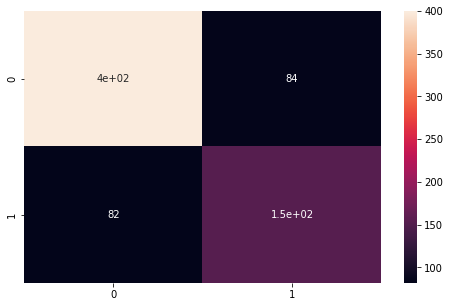

In [21]:
_ =  plt.figure(figsize=(8, 5)) 
_ = sns.heatmap(confusion_matrix(y_test,  voting_preds), annot=True)
print(classification_report(y_test.reshape(-1),  voting_preds))

logesitc Regressin Model AUC is : 0.8389392772096932


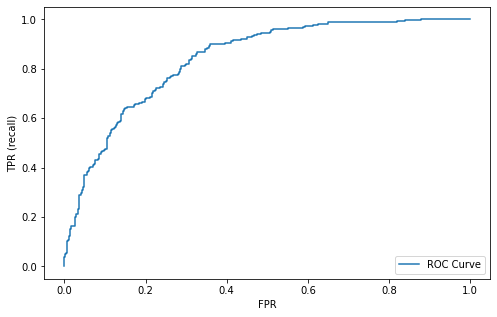

In [22]:
_ =  plt.figure(figsize=(8, 5))
fpr, tpr, thresholds = roc_curve(y_test, voting_model.predict_proba(X_test)[:, 1])
print(f'logesitc Regressin Model AUC is : {auc(fpr, tpr)}')
_ = plt.plot(fpr, tpr, label="ROC Curve")
_= plt.xlabel("FPR")
_= plt.ylabel("TPR (recall)")
_= plt.legend(loc=4)